In [559]:
import os
import seaborn as sns
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Internal Libraries
from utils.plots import plot_count_of_columns, plot_IQR, plot_categories_spread
from utils.outliers import outlier_detect
from utils.impute_missing import preprocess_pipe, fill_chronic_diseases, fill_missing_values, imputer_missing_values, empty_imputer, null_values

# Loading Dataset and Analyze Data

In [560]:
FILENAME = "side_effect_data.xlsx"
DATASET_PATH = os.path.join("dataset", FILENAME)

In [561]:
data = pd.read_excel(DATASET_PATH)

## Rename Columns

In [562]:
column_maps = {"Kullanici_id":"user_id", "Cinsiyet":"gender", "Dogum_Tarihi":"birthdate", "Uyruk":"origin", "Il": "city", "Ilac_Adi":"drug_name","Ilac_Baslangic_Tarihi":"drug_start_date",
               "Ilac_Bitis_Tarihi":"drug_end_date","Yan_Etki":"side_effect", "Yan_Etki_Bildirim_Tarihi":"side_effect_notif_date", "Alerjilerim":"allergies", "Kronik Hastaliklarim": "chronic_diseases",
               "Baba Kronik Hastaliklari":"father_chronic_diseases", "Anne Kronik Hastaliklari":"mother_chronic_diseases","Kiz Kardes Kronik Hastaliklari":"sister_chronic_diseases",
               "Erkek Kardes Kronik Hastaliklari":"brother_chronic_diseases", "Kan Grubu":"blood_type", "Kilo":"weight", "Boy":"height"}

data = data.rename(columns=column_maps)

In [563]:
data.head()

,user_id,gender,birthdate,origin,city,drug_name,drug_start_date,drug_end_date,side_effect,side_effect_notif_date,allergies,chronic_diseases,father_chronic_diseases,mother_chronic_diseases,sister_chronic_diseases,brother_chronic_diseases,blood_type,weight,height
0,107,Male,1960-03-01,Turkiye,Canakkale,trifluoperazine,2022-01-09,2022-03-04,Kabizlik,2022-02-19 18:28:43,Ceviz,"Hipertansiyon, Kan Hastaliklari","Guatr, Hipertansiyon",KOAH,"Kemik Erimesi, Kalp Hastaliklari","Kemik Erimesi, Guatr",B RH-,103.0,191.0
1,140,Male,1939-10-12,Turkiye,Trabzon,fluphenazine hcl,2022-01-09,2022-03-08,Yorgunluk,2022-02-03 20:48:17,Toz,NaN,"Guatr, Diger","Hipertansiyon, Kalp Hastaliklari",,"KOAH, Diyabet",NaN,81.0,181.0
2,2,Female,1976-12-17,Turkiye,Canakkale,warfarin sodium,2022-01-11,2022-03-12,Carpinti,2022-02-04 05:29:20,Muz,"Kalp Hastaliklari, Diyabet","Diyabet, KOAH","Kemik Erimesi, Diyabet","Diyabet, Kemik Erimesi",Diger,B RH-,93.0,158.0
3,83,Male,1977-06-17,Turkiye,Adana,valproic acid,2022-01-04,2022-03-12,Sinirlilik,2022-02-08 01:01:21,Pancar,"Diyabet, Diger","Kalp Hastaliklari, Diger",NaN,Astim,"Kalp Hastaliklari, Kanser",AB RH-,NaN,165.0
4,7,Female,1976-09-03,Turkiye,Izmir,carbamazepine extended release,2022-01-13,2022-03-06,Agizda Farkli Bir Tat,2022-02-12 05:33:06,NaN,"Diyabet, Kalp Hastaliklari","Alzheimer, Hipertansiyon","Kan Hastaliklari, Kemik Erimesi","Diyabet, Diger","Alzheimer, Hipertansiyon",AB RH-,99.0,172.0


## Create User Dataframe for unique Users

In [564]:
user_data = data.iloc[data["user_id"].drop_duplicates().index, :]
user_data.shape

(196, 19)

In [565]:
user_data.isnull().sum()

user_id                      0
gender                      65
birthdate                    0
origin                       0
city                        20
drug_name                    0
drug_start_date              0
drug_end_date                0
side_effect                  0
side_effect_notif_date       0
allergies                   41
chronic_diseases            31
father_chronic_diseases     13
mother_chronic_diseases     17
sister_chronic_diseases      8
brother_chronic_diseases    11
blood_type                  28
weight                      26
height                      10
dtype: int64

<Axes: xlabel='weight', ylabel='height'>

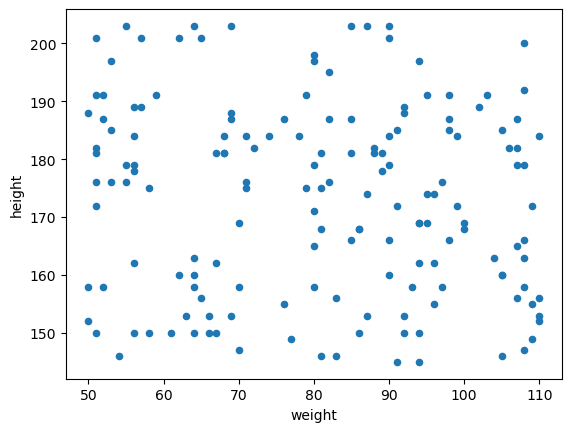

In [566]:
user_data.plot(kind="scatter", x="weight", y="height")

## Count of each Feature

Number of classes:
city
Adana        220
Ankara       179
Antalya      171
Bursa        169
Canakkale    179
Eskisehir    174
Istanbul     144
Izmir        121
Kayseri      109
Malatya      109
Mersin       207
Samsun       153
Trabzon      195
Name: origin, dtype: int64
Percentage of classes:
city
Adana        10.33
Ankara        8.40
Antalya       8.03
Bursa         7.93
Canakkale     8.40
Eskisehir     8.17
Istanbul      6.76
Izmir         5.68
Kayseri       5.12
Malatya       5.12
Mersin        9.72
Samsun        7.18
Trabzon       9.15
Name: origin, dtype: float64
count     13.000000
mean     163.846154
std       35.343189
min      109.000000
25%      144.000000
50%      171.000000
75%      179.000000
max      220.000000
Name: origin, dtype: float64


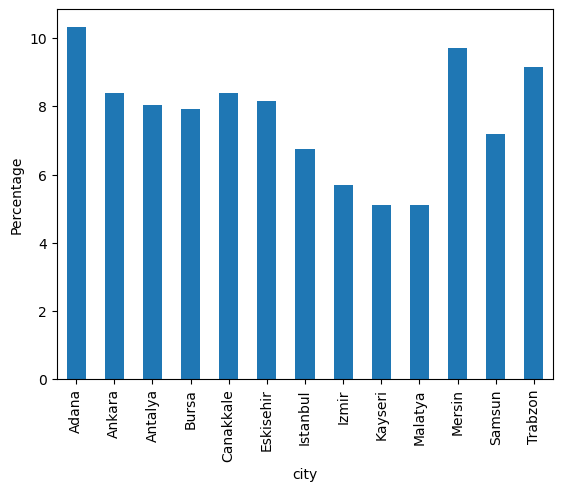

In [567]:
plot_count_of_columns(data, "city")

Number of classes:
city
Adana        16
Ankara       14
Antalya      16
Bursa        14
Canakkale    14
Eskisehir    14
Istanbul     12
Izmir        10
Kayseri       9
Malatya      10
Mersin       18
Samsun       12
Trabzon      17
Name: origin, dtype: int64
Percentage of classes:
city
Adana         9.09
Ankara        7.95
Antalya       9.09
Bursa         7.95
Canakkale     7.95
Eskisehir     7.95
Istanbul      6.82
Izmir         5.68
Kayseri       5.11
Malatya       5.68
Mersin       10.23
Samsun        6.82
Trabzon       9.66
Name: origin, dtype: float64
count    13.000000
mean     13.538462
std       2.817072
min       9.000000
25%      12.000000
50%      14.000000
75%      16.000000
max      18.000000
Name: origin, dtype: float64


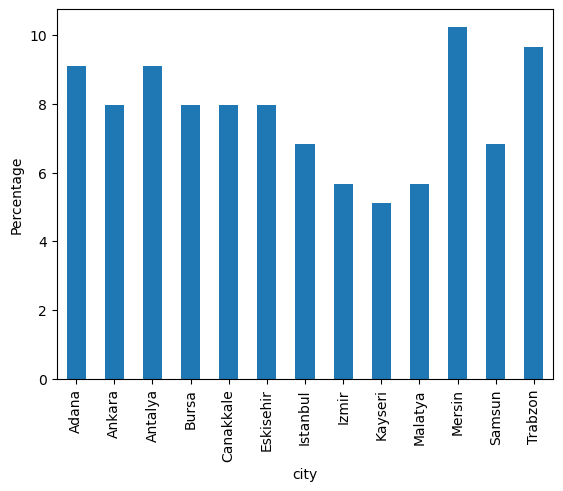

In [568]:
plot_count_of_columns(user_data, "city")

## Datetime Features

In [569]:
data["drug_start_day"] = data["drug_start_date"].dt.day
data["drug_end_day"] = data["drug_end_date"].dt.day
data["drug_interval"] = (data["drug_end_date"] - data["drug_start_date"]).dt.days
data["side_effect_notif_day"] = data["side_effect_notif_date"].dt.day
data["side_effect_notif_hour"] = data["side_effect_notif_date"].dt.hour
data["birth_year"] = pd.to_datetime(data["birthdate"]).dt.year

In [570]:
data.head()

,user_id,gender,birthdate,origin,city,drug_name,drug_start_date,drug_end_date,side_effect,side_effect_notif_date,...,brother_chronic_diseases,blood_type,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year
0,107,Male,1960-03-01,Turkiye,Canakkale,trifluoperazine,2022-01-09,2022-03-04,Kabizlik,2022-02-19 18:28:43,...,"Kemik Erimesi, Guatr",B RH-,103.0,191.0,9,4,54,19,18,1960
1,140,Male,1939-10-12,Turkiye,Trabzon,fluphenazine hcl,2022-01-09,2022-03-08,Yorgunluk,2022-02-03 20:48:17,...,"KOAH, Diyabet",NaN,81.0,181.0,9,8,58,3,20,1939
2,2,Female,1976-12-17,Turkiye,Canakkale,warfarin sodium,2022-01-11,2022-03-12,Carpinti,2022-02-04 05:29:20,...,Diger,B RH-,93.0,158.0,11,12,60,4,5,1976
3,83,Male,1977-06-17,Turkiye,Adana,valproic acid,2022-01-04,2022-03-12,Sinirlilik,2022-02-08 01:01:21,...,"Kalp Hastaliklari, Kanser",AB RH-,NaN,165.0,4,12,67,8,1,1977
4,7,Female,1976-09-03,Turkiye,Izmir,carbamazepine extended release,2022-01-13,2022-03-06,Agizda Farkli Bir Tat,2022-02-12 05:33:06,...,"Alzheimer, Hipertansiyon",AB RH-,99.0,172.0,13,6,52,12,5,1976


Number of classes:
side_effect_notif_hour
0      97
1     173
3     143
4     152
5     220
6     149
7     235
8     125
11    135
13    132
14     73
16     76
17     78
18     87
19    125
20    123
21     88
22     78
23     68
Name: origin, dtype: int64
Percentage of classes:
side_effect_notif_hour
0     4.12
1     7.34
3     6.07
4     6.45
5     9.33
6     6.32
7     9.97
8     5.30
11    5.73
13    5.60
14    3.10
16    3.22
17    3.31
18    3.69
19    5.30
20    5.22
21    3.73
22    3.31
23    2.89
Name: origin, dtype: float64
count     19.000000
mean     124.052632
std       48.052603
min       68.000000
25%       82.500000
50%      125.000000
75%      146.000000
max      235.000000
Name: origin, dtype: float64


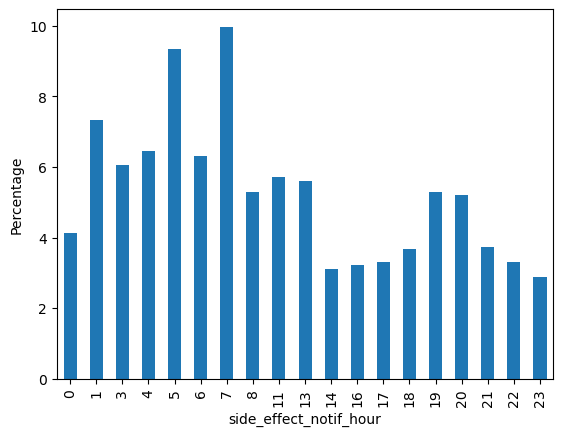

In [571]:
plot_count_of_columns(data, "side_effect_notif_hour")

In [572]:
data = data.astype({"user_id":"object"})
data["age_group"] = pd.cut(data["birth_year"],
 bins=[1930, 1950, 1970, 1990, 2010, 2040],
 labels=[1, 2, 3, 4, 5])
data["age"] = 2024 - data["birth_year"].astype(int)
data["bmi"] = (data["weight"] / data["height"]**2) * 10e3

In [573]:
data.describe()

,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
count,2064.000000,2243.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,2357.000000,1950.000000
mean,80.863857,174.638431,7.449724,10.684345,62.234620,10.268562,10.243106,1974.409419,49.590581,27.572163
std,18.635269,16.516552,4.069499,5.118675,6.576611,6.245644,7.045983,20.076783,20.076783,8.822664
min,50.000000,145.000000,1.000000,2.000000,47.000000,1.000000,0.000000,1939.000000,13.000000,12.623450
25%,65.000000,160.000000,4.000000,6.000000,58.000000,4.000000,5.000000,1959.000000,32.000000,20.756387
50%,83.000000,176.000000,7.000000,11.000000,62.000000,9.000000,8.000000,1973.000000,51.000000,26.709402
75%,96.000000,187.000000,11.000000,15.000000,67.000000,17.000000,17.000000,1992.000000,65.000000,32.912013
max,110.000000,203.000000,14.000000,19.000000,77.000000,19.000000,23.000000,2011.000000,85.000000,49.979175


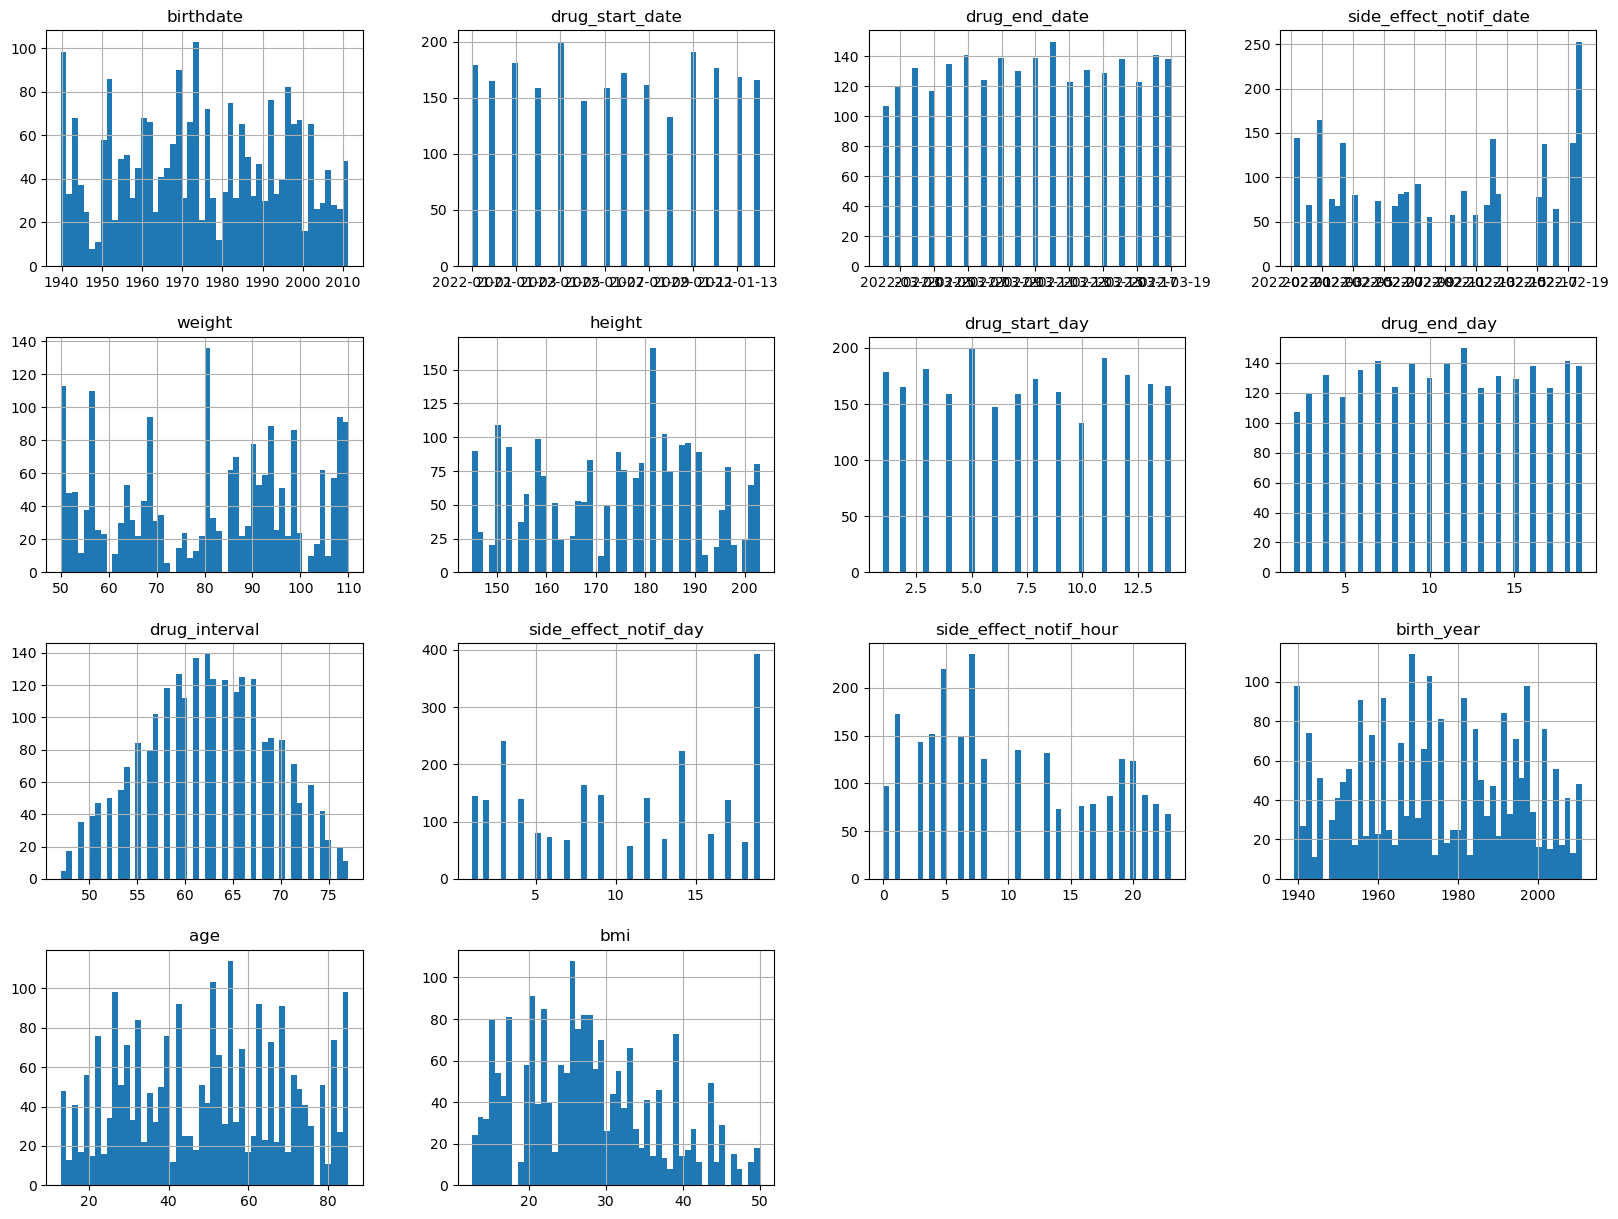

In [574]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.show()

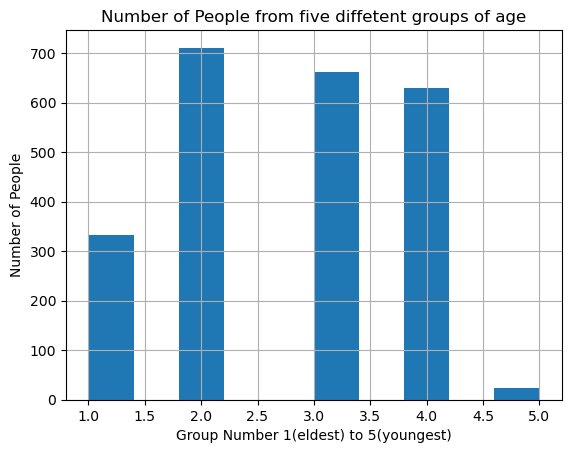

In [575]:
data["age_group"].hist()
plt.title("Number of People from five diffetent groups of age")
plt.xlabel("Group Number 1(eldest) to 5(youngest)")
plt.ylabel("Number of People")
plt.show()

## High Correlations
Weight - bmi 
height - bmi
drug_start_day - drug_interval
drug_end_day - drug_interval
birth_year age birth year will be dropped

C:\Users\sceli\AppData\Local\Temp\ipykernel_1184\751783092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = data.corr()


,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
weight,1.000000,-0.149016,0.015008,-0.006739,-0.014538,0.000033,-0.006946,-0.026321,0.026321,0.798079
height,-0.149016,1.000000,-0.040572,0.010633,0.033448,-0.005868,-0.018179,0.002952,-0.002952,-0.692869
drug_start_day,0.015008,-0.040572,1.000000,-0.011765,-0.627941,0.021364,-0.009232,-0.010052,0.010052,0.029516
drug_end_day,-0.006739,0.010633,-0.011765,1.000000,0.785595,0.008202,-0.008428,0.017304,-0.017304,-0.010468
drug_interval,-0.014538,0.033448,-0.627941,0.785595,1.000000,-0.006836,-0.000847,0.019688,-0.019688,-0.026466
side_effect_notif_day,0.000033,-0.005868,0.021364,0.008202,-0.006836,1.000000,0.141822,-0.014448,0.014448,-0.003707
side_effect_notif_hour,-0.006946,-0.018179,-0.009232,-0.008428,-0.000847,0.141822,1.000000,0.001765,-0.001765,-0.010752
birth_year,-0.026321,0.002952,-0.010052,0.017304,0.019688,-0.014448,0.001765,1.000000,-1.000000,-0.055783
age,0.026321,-0.002952,0.010052,-0.017304,-0.019688,0.014448,-0.001765,-1.000000,1.000000,0.055783
bmi,0.798079,-0.692869,0.029516,-0.010468,-0.026466,-0.003707,-0.010752,-0.055783,0.055783,1.000000


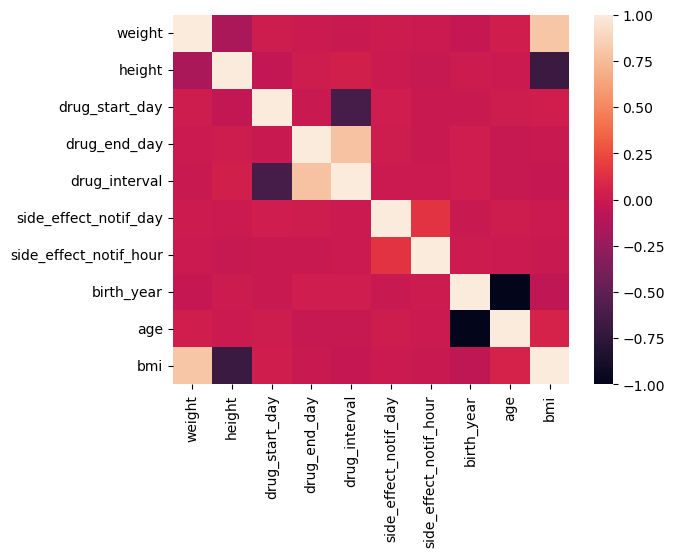

In [576]:
corr_mat = data.corr()
display(corr_mat)
sns.heatmap(corr_mat)
plt.show()

# Train Test Split

In [577]:
from sklearn.model_selection import train_test_split
import numpy as np

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)


In [578]:
len(train_set), len(test_set)

(1885, 472)

### Stratified Split

In [579]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data["age_group"]):
    strat_train_set = data.loc[train_index]
    strat_test_set = data.loc[test_index]


In [580]:
len(strat_train_set), len(strat_test_set)

(1885, 472)

#### Normal test set vs Stratified test set age_group class ratio 1(1930-1950) to 5(2010-) 

In [581]:
strat_train_set["age_group"].value_counts() / len(strat_train_set)

2    0.301857
3    0.280637
4    0.266844
1    0.140584
5    0.010080
Name: age_group, dtype: float64

In [582]:
strat_test_set["age_group"].value_counts() / len(strat_test_set)

2    0.300847
3    0.279661
4    0.266949
1    0.141949
5    0.010593
Name: age_group, dtype: float64

In [583]:
train_set["age_group"].value_counts() /len(train_set)

2    0.296021
3    0.278515
4    0.269496
1    0.146419
5    0.009549
Name: age_group, dtype: float64

In [584]:
(test_set["age_group"].value_counts() /len(test_set)).sort_index()

1    0.118644
2    0.324153
3    0.288136
4    0.256356
5    0.012712
Name: age_group, dtype: float64

In [585]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("age_group", axis=1, inplace=True)


# Preprocess and Train

In [586]:
df_train = strat_train_set.copy()
df_train.head()

,user_id,gender,birthdate,origin,city,drug_name,drug_start_date,drug_end_date,side_effect,side_effect_notif_date,...,weight,height,drug_start_day,drug_end_day,drug_interval,side_effect_notif_day,side_effect_notif_hour,birth_year,age,bmi
958,134,NaN,1996-09-10,Turkiye,Adana,mometasone furoate ointment,2022-01-07,2022-03-11,Gec Bosalma,2022-02-14 07:26:11,...,80.0,197.0,7,11,63,14,7,1996,28,20.613775
936,167,Female,1944-10-29,Turkiye,Trabzon,paroxetine,2022-01-04,2022-03-12,Agizda Farkli Bir Tat,2022-02-04 08:08:31,...,50.0,158.0,4,12,67,4,8,1944,80,20.028842
301,140,Male,1939-10-12,Turkiye,Trabzon,alprazolam,2022-01-10,2022-03-02,Istah Artisi,2022-02-17 07:08:01,...,81.0,181.0,10,2,51,17,7,1939,85,24.724520
1671,70,Female,1943-04-25,Turkiye,Kayseri,mirtazapine,2022-01-02,2022-03-17,Gucsuzluk,2022-02-01 04:34:33,...,NaN,200.0,2,17,74,1,4,1943,81,NaN
1484,15,Female,1959-12-19,Turkiye,Ankara,lorazepam concentrate,2022-01-01,2022-03-15,Sinirlilik,2022-02-08 01:01:21,...,69.0,188.0,1,15,73,8,1,1959,65,19.522408


## Missing Values

In [587]:
null_values(data)

gender                      778
allergies                   484
bmi                         407
chronic_diseases            392
blood_type                  347
weight                      293
city                        227
mother_chronic_diseases     217
father_chronic_diseases     156
brother_chronic_diseases    121
height                      114
sister_chronic_diseases      97
side_effect_notif_date        0
side_effect                   0
drug_end_date                 0
drug_start_date               0
drug_name                     0
origin                        0
birthdate                     0
drug_start_day                0
drug_end_day                  0
drug_interval                 0
side_effect_notif_day         0
side_effect_notif_hour        0
birth_year                    0
age_group                     0
age                           0
user_id                       0
dtype: int64


In [588]:
df_train, df_test = strat_train_set.copy(), strat_test_set.copy()

In [589]:
missing_diseases = ["chronic_diseases", "mother_chronic_diseases","father_chronic_diseases", "brother_chronic_diseases", "sister_chronic_diseases"]

In [590]:
df_train, df_test = preprocess_pipe(df_train, missing_diseases), preprocess_pipe(df_test, missing_diseases)

gender                      630
allergies                   379
bmi                         322
chronic_diseases            319
blood_type                  274
weight                      233
city                        190
mother_chronic_diseases     167
father_chronic_diseases     123
brother_chronic_diseases     95
height                       89
sister_chronic_diseases      73
side_effect                   0
drug_end_day                  0
age                           0
birth_year                    0
side_effect_notif_hour        0
side_effect_notif_day         0
drug_interval                 0
birthdate                     0
drug_start_day                0
side_effect_notif_date        0
origin                        0
drug_name                     0
drug_start_date               0
drug_end_date                 0
user_id                       0
dtype: int64
Before filling missing data:
 None


user_id                     0
sister_chronic_diseases     0
age                         0
birth_year                  0
side_effect_notif_hour      0
side_effect_notif_day       0
drug_interval               0
drug_end_day                0
drug_start_day              0
height                      0
weight                      0
blood_type                  0
brother_chronic_diseases    0
mother_chronic_diseases     0
gender                      0
father_chronic_diseases     0
chronic_diseases            0
allergies                   0
side_effect_notif_date      0
side_effect                 0
drug_end_date               0
drug_start_date             0
drug_name                   0
city                        0
origin                      0
birthdate                   0
bmi                         0
dtype: int64
After filling:
None
gender                      148
allergies                   105
bmi                          85
blood_type                   73
chronic_diseases             

<Axes: >

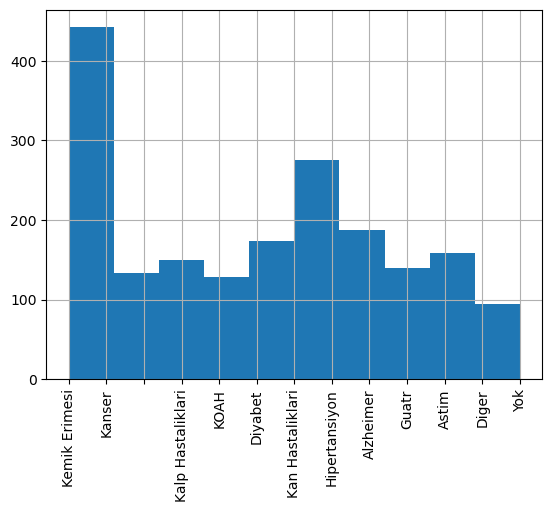

In [591]:
df_train["sister_chronic_diseases_1"].hist(xrot=90)

In [592]:
mis_diseases = [disease+"_1" for disease in missing_diseases]
diseases = list(mis_diseases)
for column in mis_diseases:
    print(f"\n-------------------------------------------------------\n{column}")
    print(len(df_train[df_train[column] == "Yok"]))
    df_train = fill_chronic_diseases(df_train, column, diseases)
    print(len(df_train[df_train[column] == "Yok"]))
    print(f"\n--------------------------------------------------------------\n")


-------------------------------------------------------
chronic_diseases_1
319
BMI High: ['Yok', 'Alzheimer', 'KOAH', 'Kemik Erimesi', 'Astim', 'Diyabet', 'Kanser']
305

--------------------------------------------------------------


-------------------------------------------------------
mother_chronic_diseases_1
167
BMI High: ['Guatr', 'KOAH', 'Diyabet', 'Yok', 'Kemik Erimesi', 'Kanser', ' ', 'Diger', 'Kan Hastaliklari']
167

--------------------------------------------------------------


-------------------------------------------------------
father_chronic_diseases_1
123
BMI High: ['Astim', 'KOAH', 'Kemik Erimesi', 'Kalp Hastaliklari', 'Hipertansiyon', 'Guatr', 'Kan Hastaliklari', 'Alzheimer', 'Diyabet']
118

--------------------------------------------------------------


-------------------------------------------------------
brother_chronic_diseases_1
95
BMI High: ['Astim', ' ', 'Diyabet', 'Alzheimer', 'Guatr', 'Yok', 'Kemik Erimesi', 'Kalp Hastaliklari', 'Kan Hastaliklari']


In [593]:
num_attrs = ["weight", "height", "birth_year", "age", "bmi", "drug_start_day", "drug_end_day", "drug_interval", "side_effect_notif_day", "side_effect_notif_hour"]
ord_cat_attrs = []
nom_cat_attrs = ["user_id", "gender","city", "drug_name", "allergies", "chronic_diseases_1", "chronic_diseases_2", "father_chronic_diseases_1","father_chronic_diseases_2", 
                 "mother_chronic_diseases_1","mother_chronic_diseases_2", "sister_chronic_diseases_1","sister_chronic_diseases_2", "brother_chronic_diseases_1","brother_chronic_diseases_2", "blood_type"]
len(num_attrs) + len(ord_cat_attrs) + len(nom_cat_attrs), len(df_train.columns)

(26, 27)

In [594]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),
 ])


In [595]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder


full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attrs),
 ("nom_cat", OrdinalEncoder(), nom_cat_attrs)
 ])

test_prepared = full_pipeline.fit_transform(df_test)
train_prepared = full_pipeline.fit_transform(df_train)

In [596]:
df_train

,user_id,gender,city,drug_name,side_effect,allergies,blood_type,weight,height,drug_start_day,...,chronic_diseases_1,chronic_diseases_2,mother_chronic_diseases_1,mother_chronic_diseases_2,father_chronic_diseases_1,father_chronic_diseases_2,brother_chronic_diseases_1,brother_chronic_diseases_2,sister_chronic_diseases_1,sister_chronic_diseases_2
958,134,Yok,Adana,mometasone furoate ointment,Gec Bosalma,Yogurt,0 RH-,80.000000,197.0,7,...,KOAH,Diger,Yok,Yok,KOAH,Guatr,Kemik Erimesi,Yok,Kemik Erimesi,Alzheimer
936,167,Female,Trabzon,paroxetine,Agizda Farkli Bir Tat,Istiridye,A RH-,50.000000,158.0,4,...,Kalp Hastaliklari,Kanser,Kalp Hastaliklari,Yok,Hipertansiyon,Kan Hastaliklari,,Yok,Kanser,Hipertansiyon
301,140,Male,Trabzon,alprazolam,Istah Artisi,Toz,Yok,81.000000,181.0,10,...,Yok,Yok,Hipertansiyon,Kalp Hastaliklari,Guatr,Diger,KOAH,Diyabet,,Yok
1671,70,Female,Kayseri,mirtazapine,Gucsuzluk,Havyar,B RH+,77.375000,200.0,2,...,Alzheimer,Yok,Hipertansiyon,Kan Hastaliklari,Guatr,Kemik Erimesi,Alzheimer,Kalp Hastaliklari,Kalp Hastaliklari,Kanser
1484,15,Female,Ankara,lorazepam concentrate,Sinirlilik,Kopek,B RH+,69.000000,188.0,1,...,Alzheimer,Hipertansiyon,Astim,Yok,Astim,Kemik Erimesi,KOAH,Alzheimer,KOAH,Diyabet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,98,Female,Samsun,cariprazine,Ishal,Yok,AB RH-,78.358450,195.0,8,...,Alzheimer,Diger,Guatr,Kemik Erimesi,Kan Hastaliklari,Yok,Kalp Hastaliklari,Guatr,KOAH,Kemik Erimesi
255,140,Male,Trabzon,desipramine,Yorgunluk,Toz,Yok,81.000000,181.0,5,...,Yok,Yok,Hipertansiyon,Kalp Hastaliklari,Guatr,Diger,KOAH,Diyabet,,Yok
1650,13,Female,Canakkale,imipramine pamoate,Yorgunluk,Kabak Cekirdegi,AB RH+,56.000000,189.0,7,...,Kan Hastaliklari,KOAH,KOAH,Alzheimer,Kemik Erimesi,Yok,Kemik Erimesi,Diyabet,Alzheimer,Astim
1334,190,Male,Ankara,"desvenlafaxine succinate tablet, extended rele...",Huzursuzluk,Kahve,0 RH+,70.000000,169.0,4,...,Kan Hastaliklari,Kalp Hastaliklari,Kemik Erimesi,Diger,Kan Hastaliklari,Astim,Diyabet,Alzheimer,Astim,Kemik Erimesi


## Ordinal Encoder Feature Importance Predicting Side Effect

In [597]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

target_var = ["side_effect"]

X_train, y_train = df_train.drop(target_var, axis=1), df_train[target_var].values
X_test, y_test = df_test.drop(target_var, axis=1), df_test[target_var].values

feature_names = X_train.columns.values

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.fit_transform(X_test)


clf = RandomForestClassifier().fit(X_train, y_train)

param_grid = [
 {'bootstrap': [False], 'max_depth': [5, 10, 15], 'max_features': ['sqrt','log2'], 'n_estimators': [1000], 'min_samples_split': [3, 4, 5]},
 ]

grid_search = GridSearchCV(clf, param_grid, cv=5,
 scoring='accuracy',
return_train_score=True)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)



C:\Users\sceli\AppData\Local\Temp\ipykernel_1184\1166875102.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier().fit(X_train, y_train)
d:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
d:\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please cha

{'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 1000}
0.46684350132625996 {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 1000}
0.47108753315649865 {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 1000}
0.47639257294429704 {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 1000}
0.41432360742705565 {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 1000}
0.413262599469496 {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 1000}
0.4106100795755968 {'bootstrap': False, 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 1000}
0.7708222811671087 {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 1000}
0.7687

In [613]:
clf = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=5, bootstrap=False, n_estimators=1000, random_state=42).fit(X_train, y_train)

C:\Users\sceli\AppData\Local\Temp\ipykernel_1184\233595320.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_split=5, bootstrap=False, n_estimators=1000, random_state=42).fit(X_train, y_train)


In [614]:
importances = clf.feature_importances_
print(len(importances), len(feature_names))
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False) 
print(feature_imp_df)

26 26
                       Feature  Gini Importance
9                 drug_end_day         0.337078
8               drug_start_day         0.274283
13                  birth_year         0.038893
7                       height         0.031874
6                       weight         0.030248
5                   blood_type         0.029619
4                    allergies         0.017860
10               drug_interval         0.017392
0                      user_id         0.017171
1                       gender         0.015705
14                         age         0.014464
3                    drug_name         0.014245
2                         city         0.014007
12      side_effect_notif_hour         0.013423
17          chronic_diseases_2         0.012501
21   father_chronic_diseases_2         0.012244
19   mother_chronic_diseases_2         0.012230
15                         bmi         0.012077
25   sister_chronic_diseases_2         0.012051
23  brother_chronic_diseases_2    

<Axes: ylabel='Feature'>

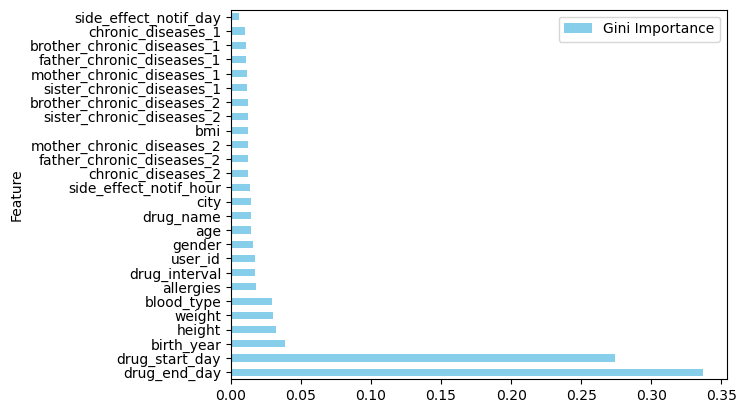

In [615]:
feature_imp_df.plot(kind="barh", x="Feature", y="Gini Importance", color='skyblue')

## Outliers

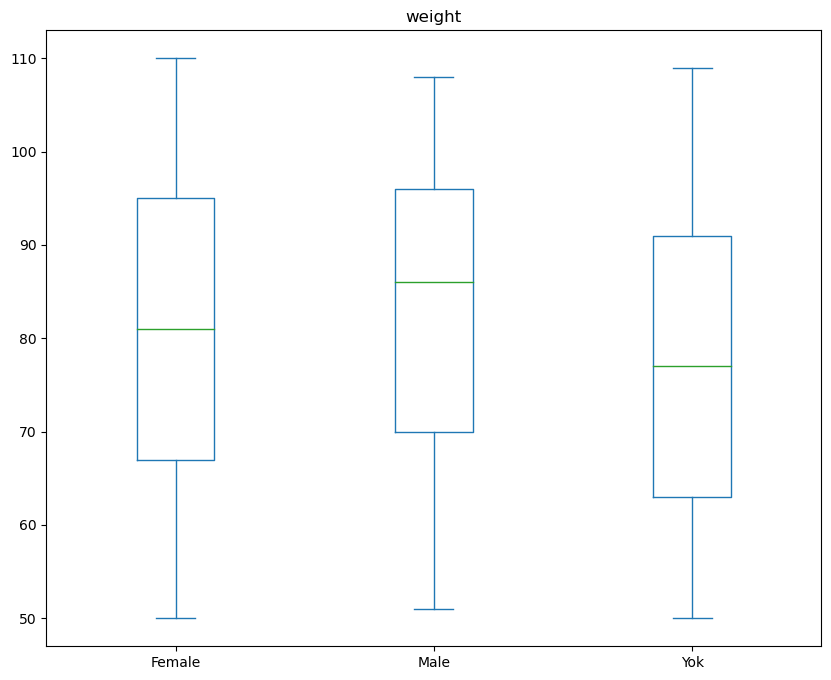

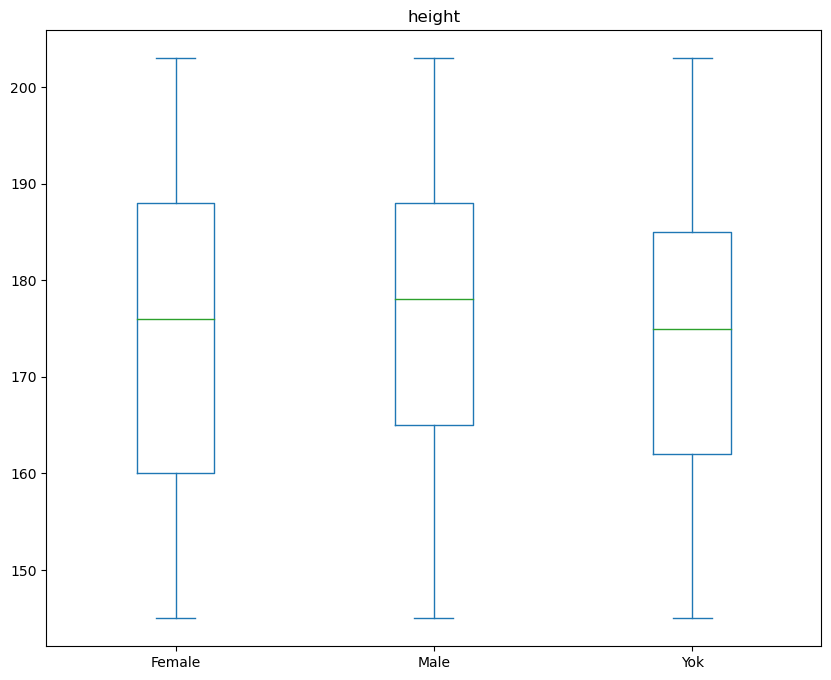

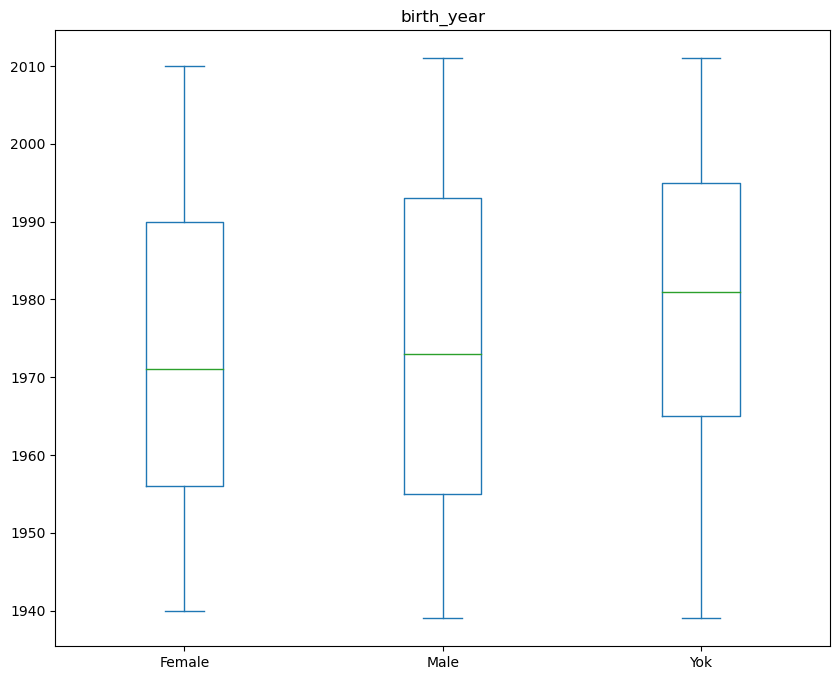

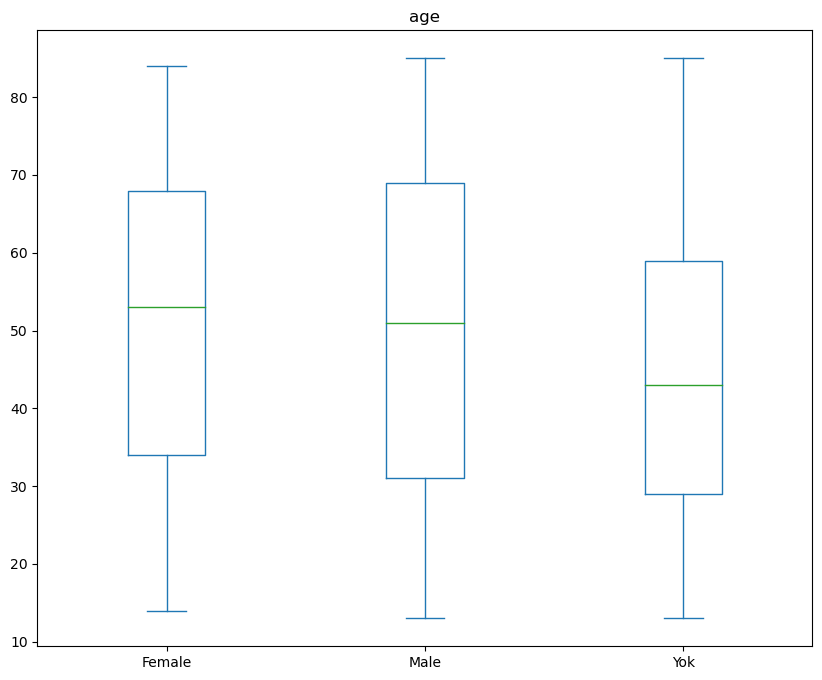

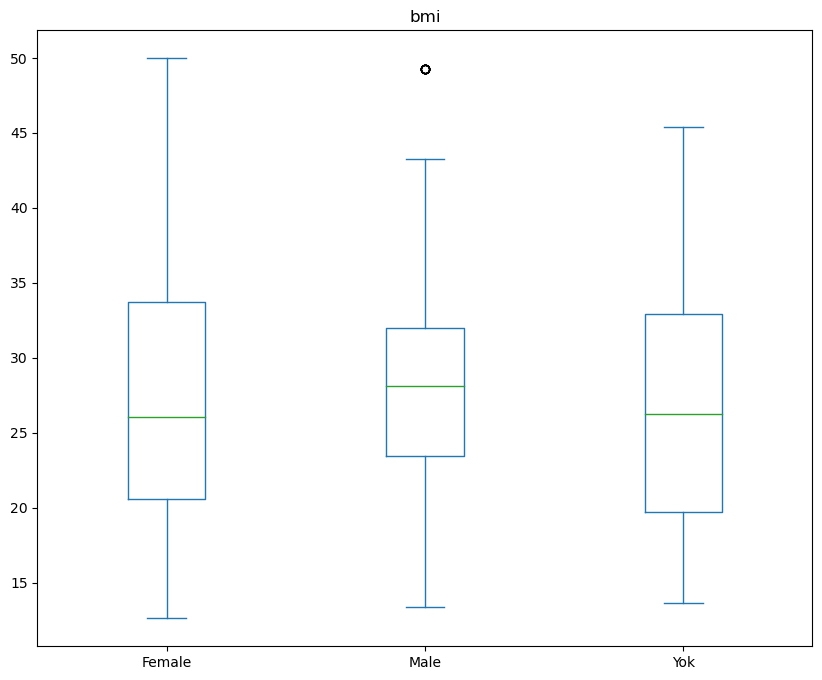

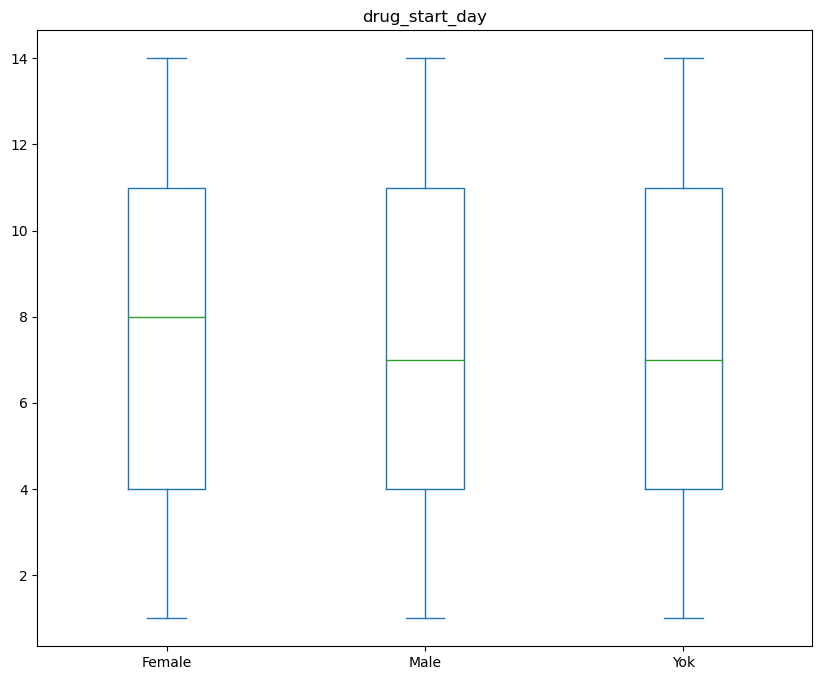

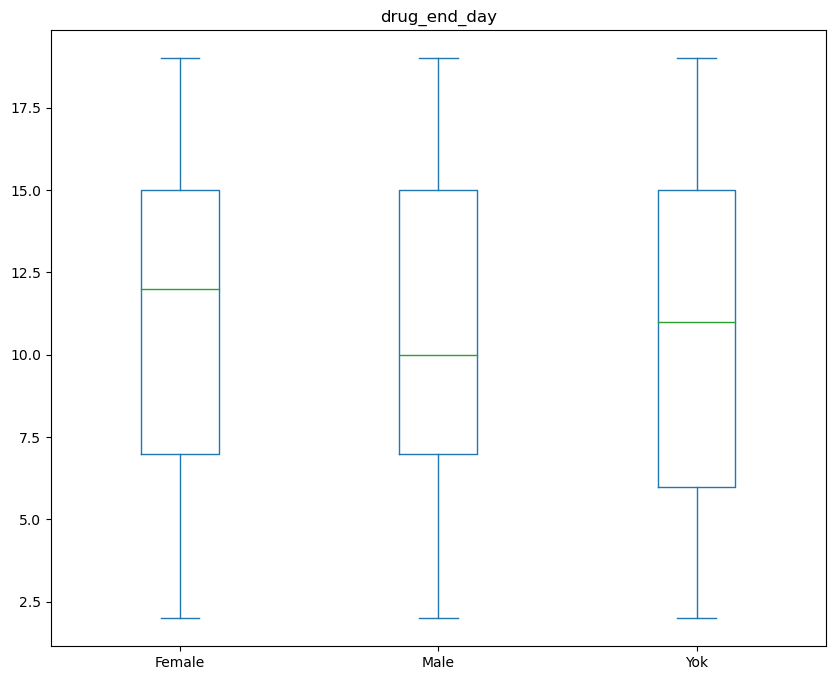

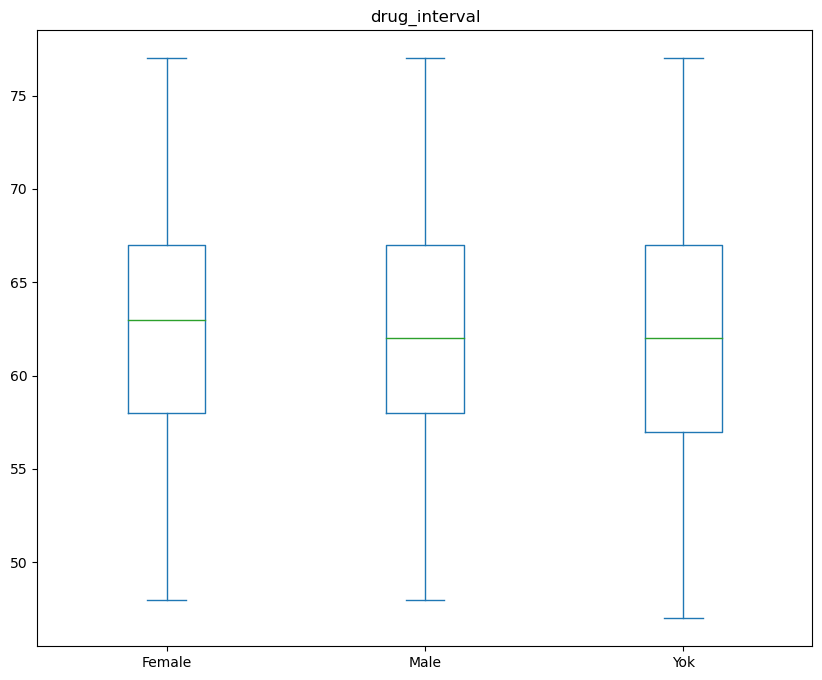

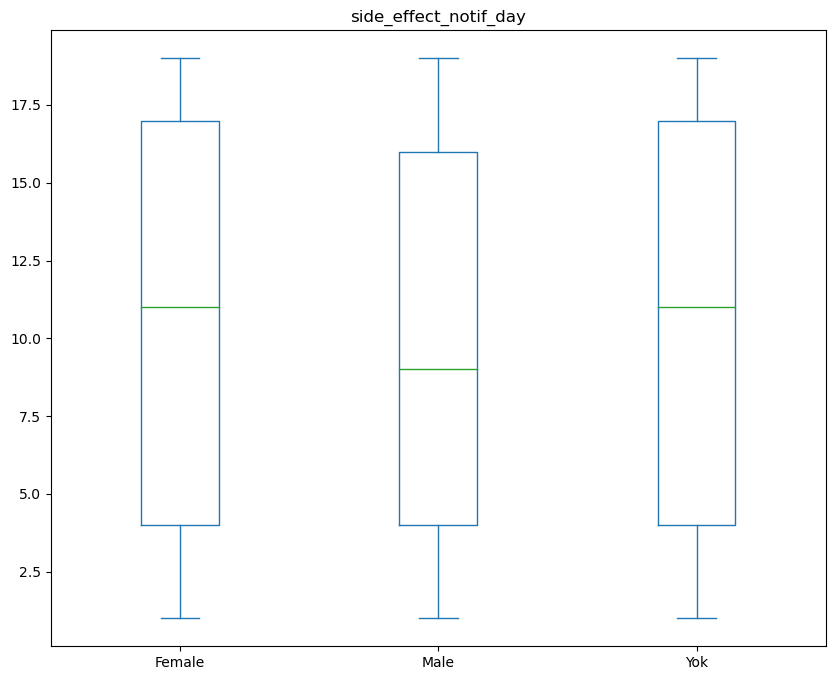

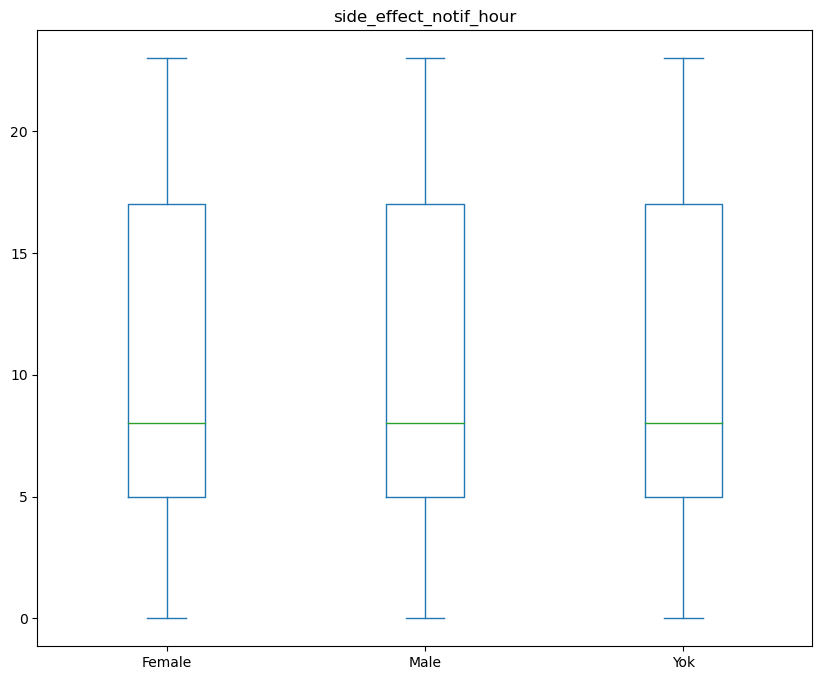

In [601]:
for col in num_attrs:
    plot_IQR(df_train,col)

In [602]:
outlier_detect(df_train[num_attrs])

Before data preprocess:
Skewness:
 weight                   -0.109103
height                   -0.148114
birth_year               -0.035445
age                       0.035445
bmi                       0.496764
drug_start_day            0.036617
drug_end_day             -0.032704
drug_interval            -0.056719
side_effect_notif_day     0.029600
side_effect_notif_hour    0.335697
dtype: float64
            weight       height   birth_year          age          bmi  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     80.563257   175.088197  1974.407958    49.592042    27.164584   
std      17.575896    16.135759    19.990514    19.990514     8.539144   
min      50.000000   145.000000  1939.000000    13.000000    12.623450   
25%      67.000000   162.000000  1959.000000    32.000000    20.613775   
50%      81.000000   177.847413  1973.000000    51.000000    26.566840   
75%      94.000000   187.000000  1992.000000    65.000000    32.912013   
max     

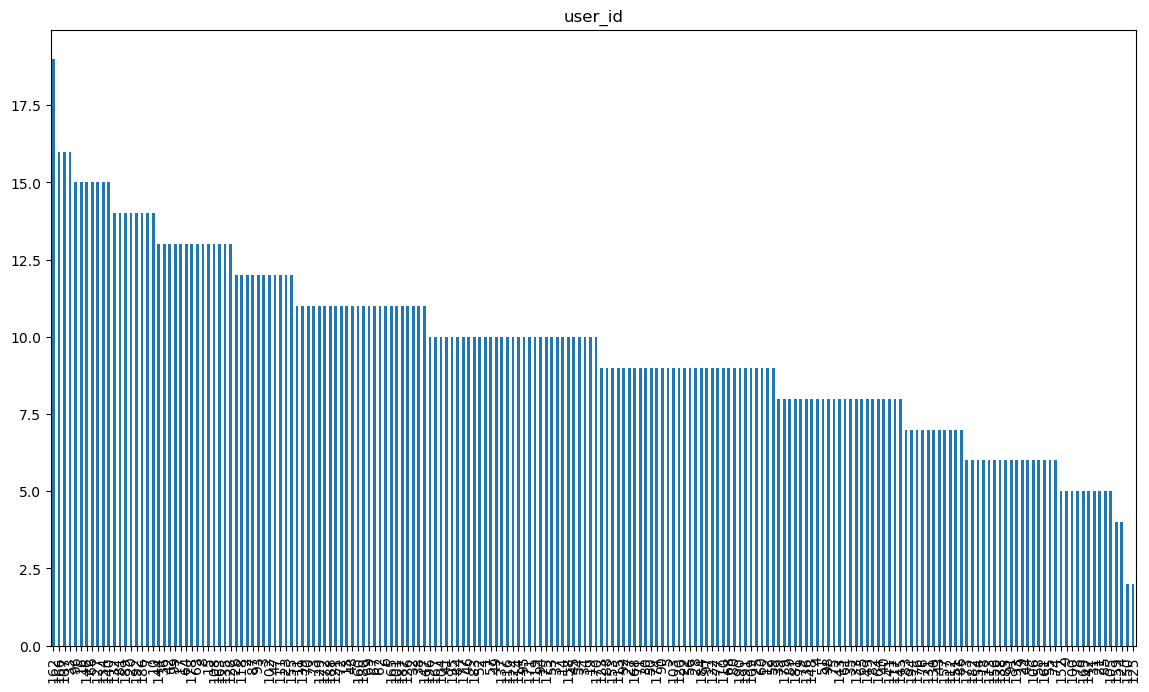

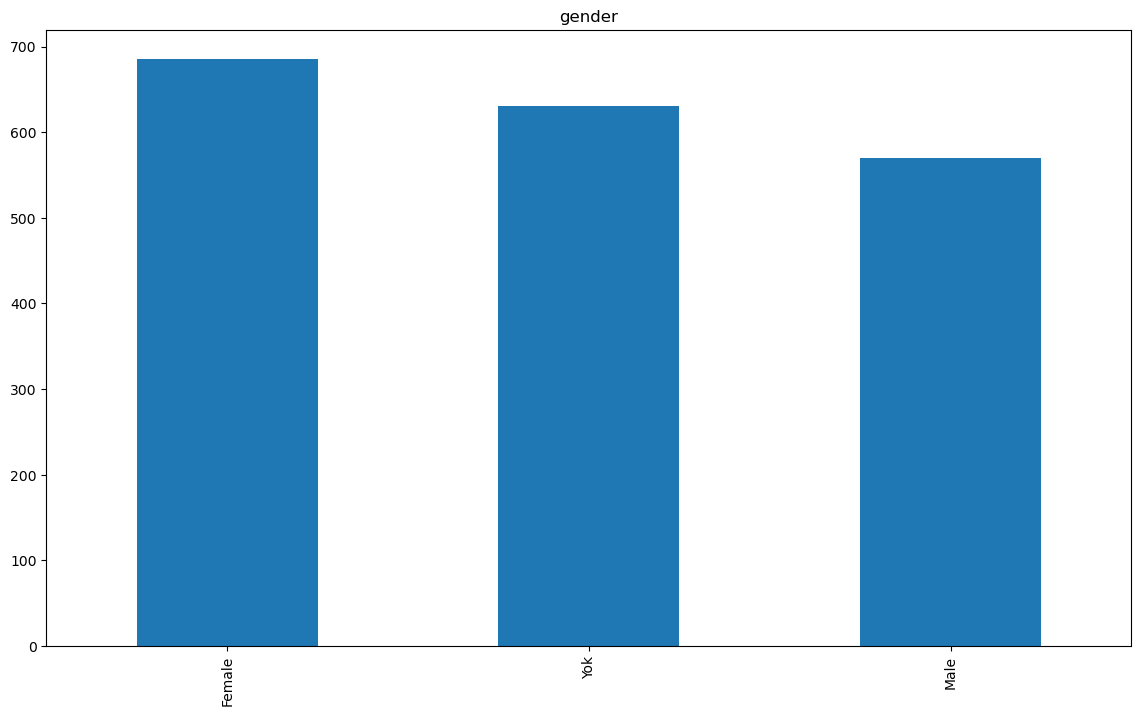

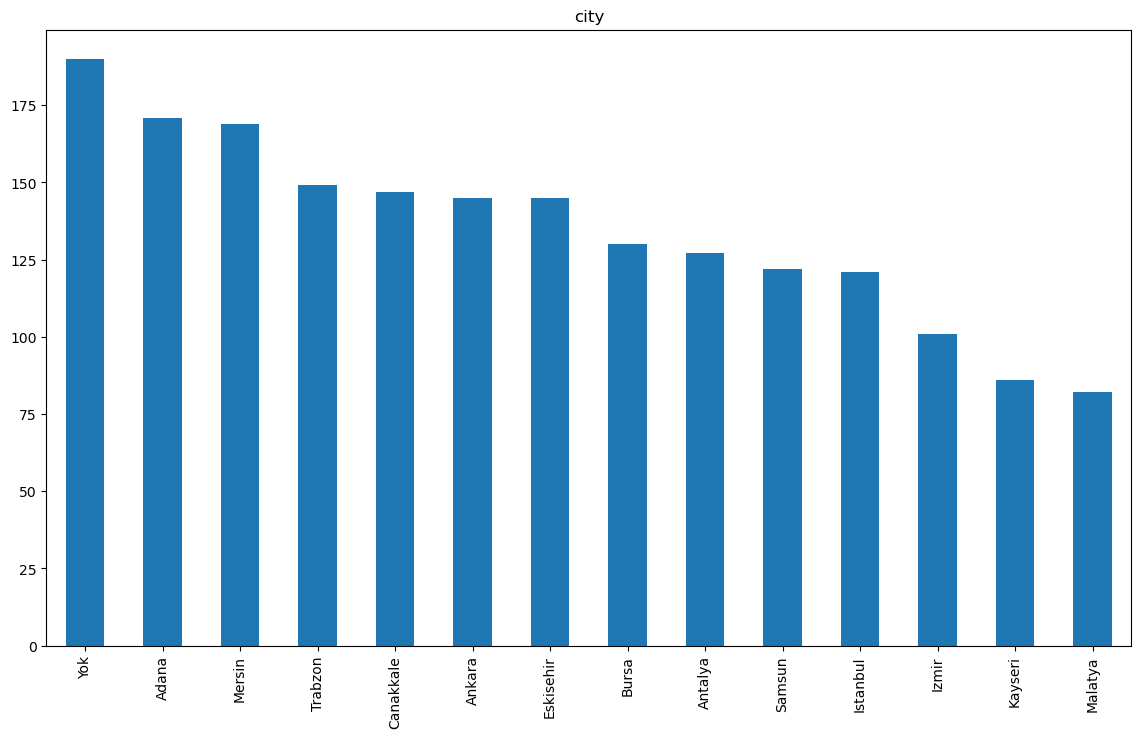

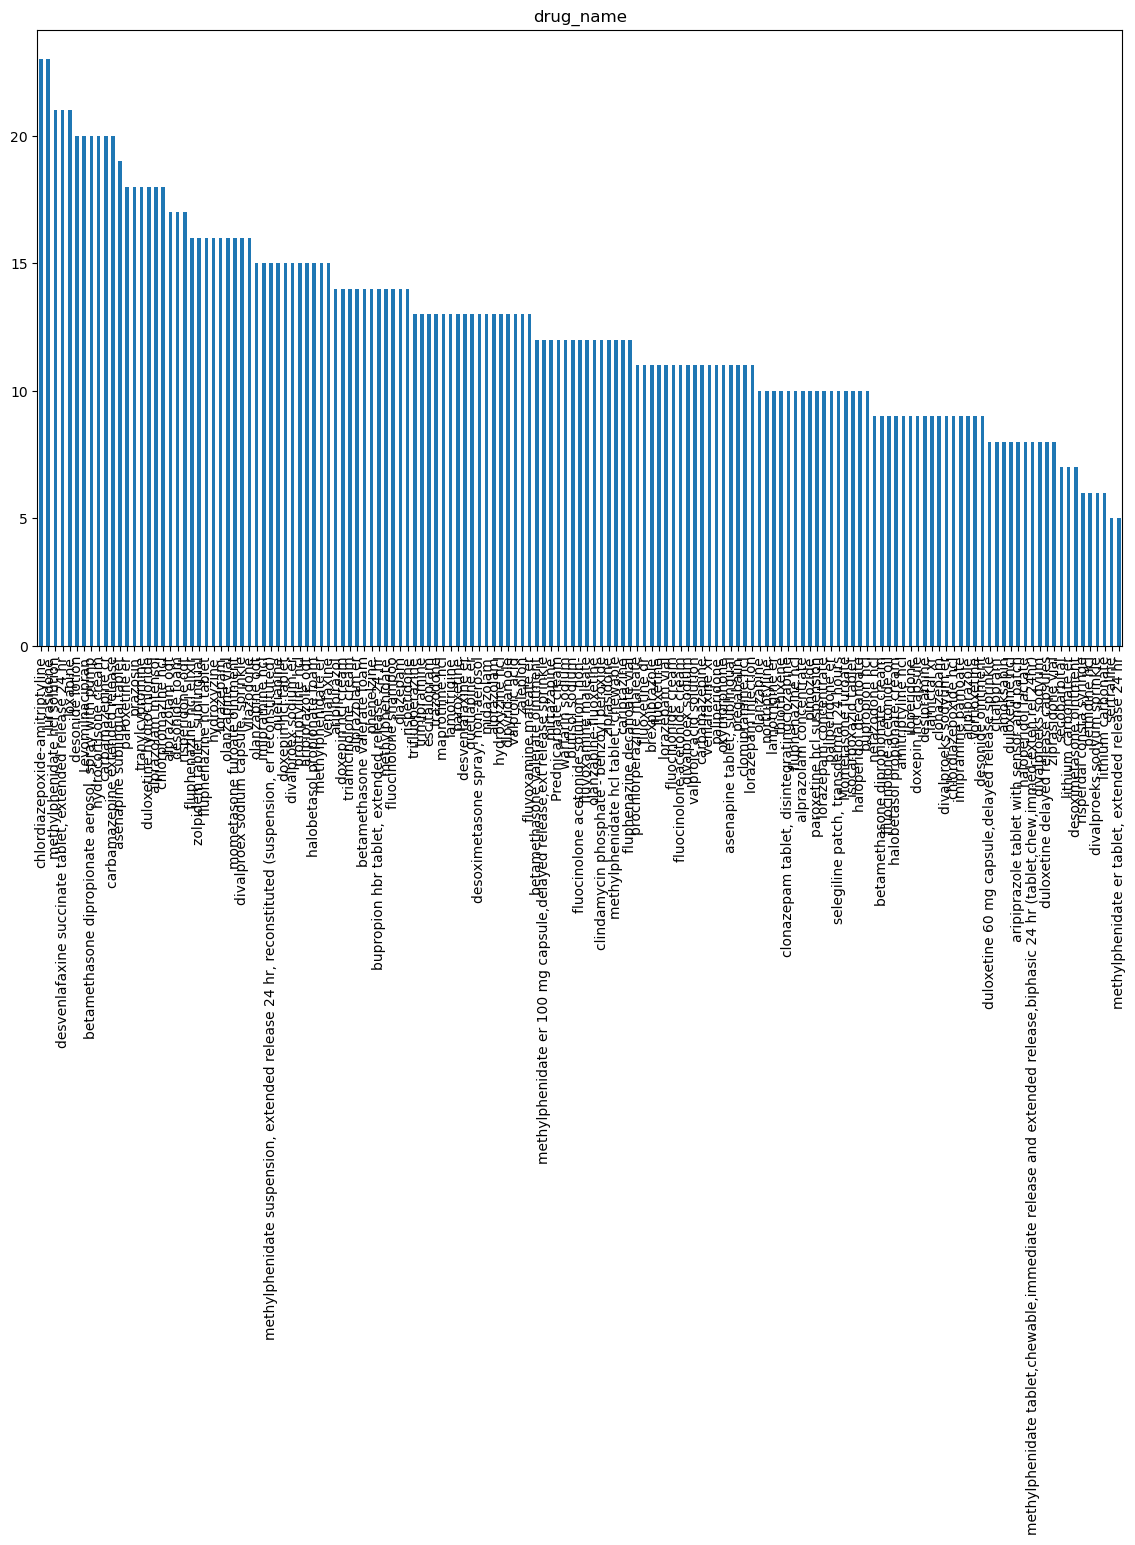

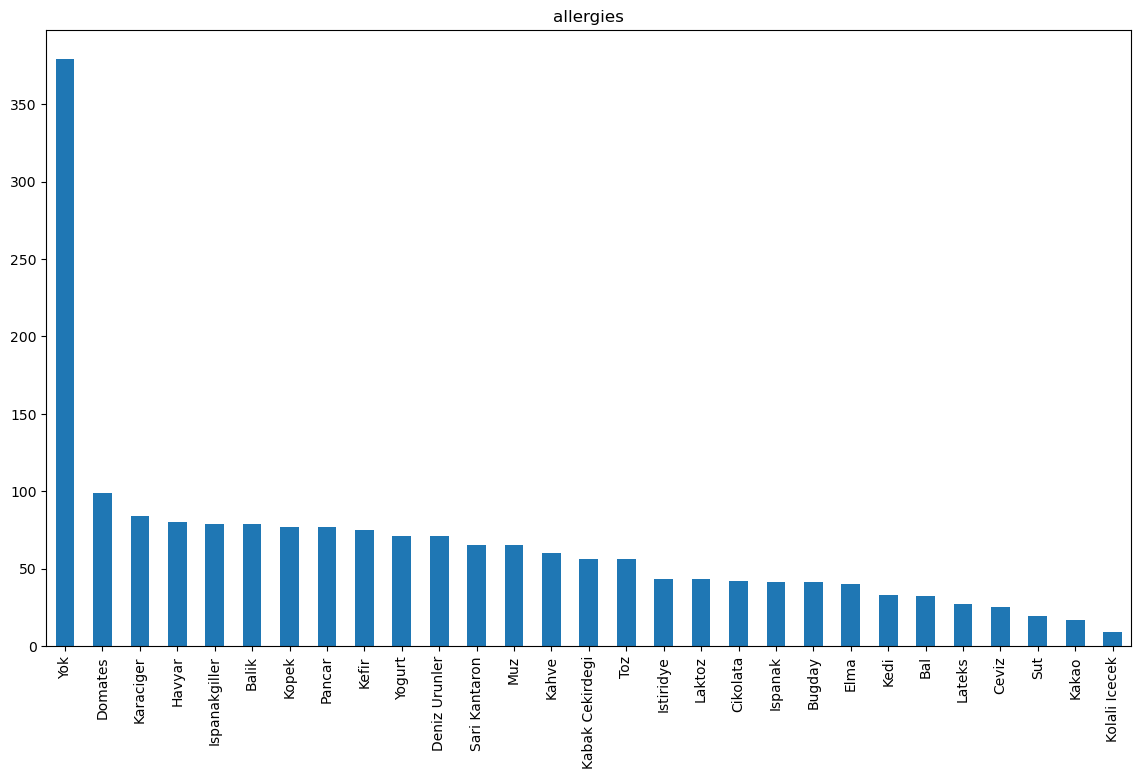

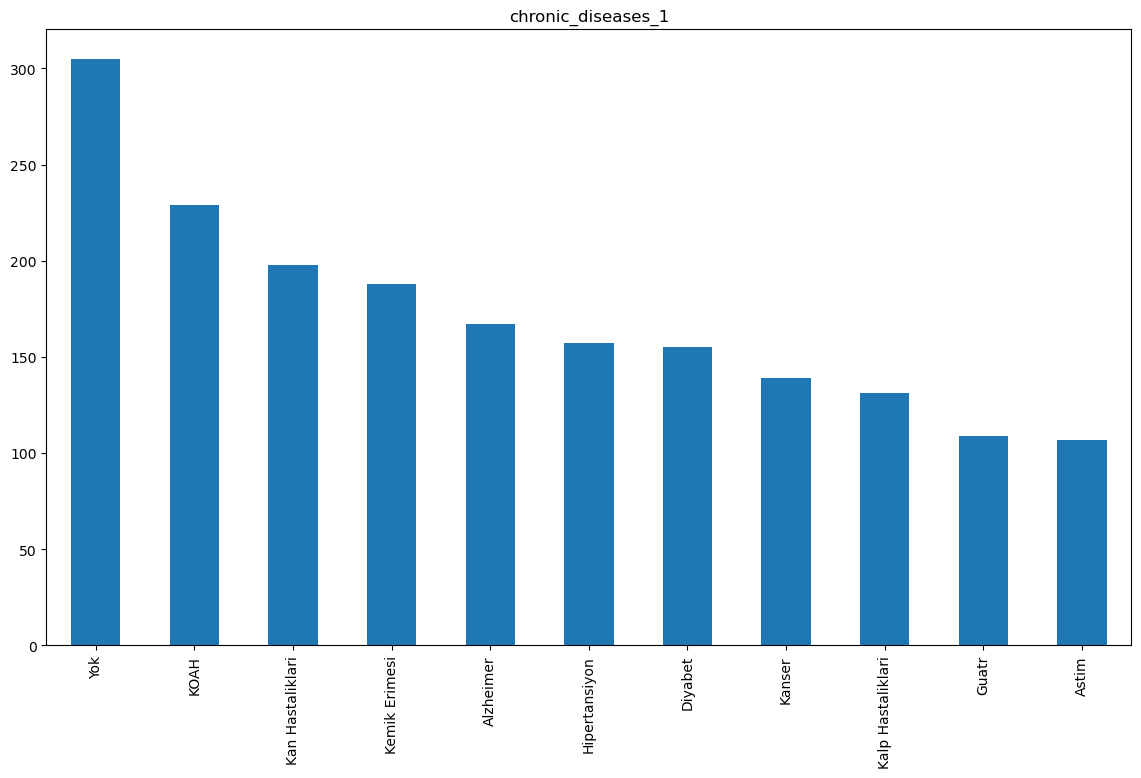

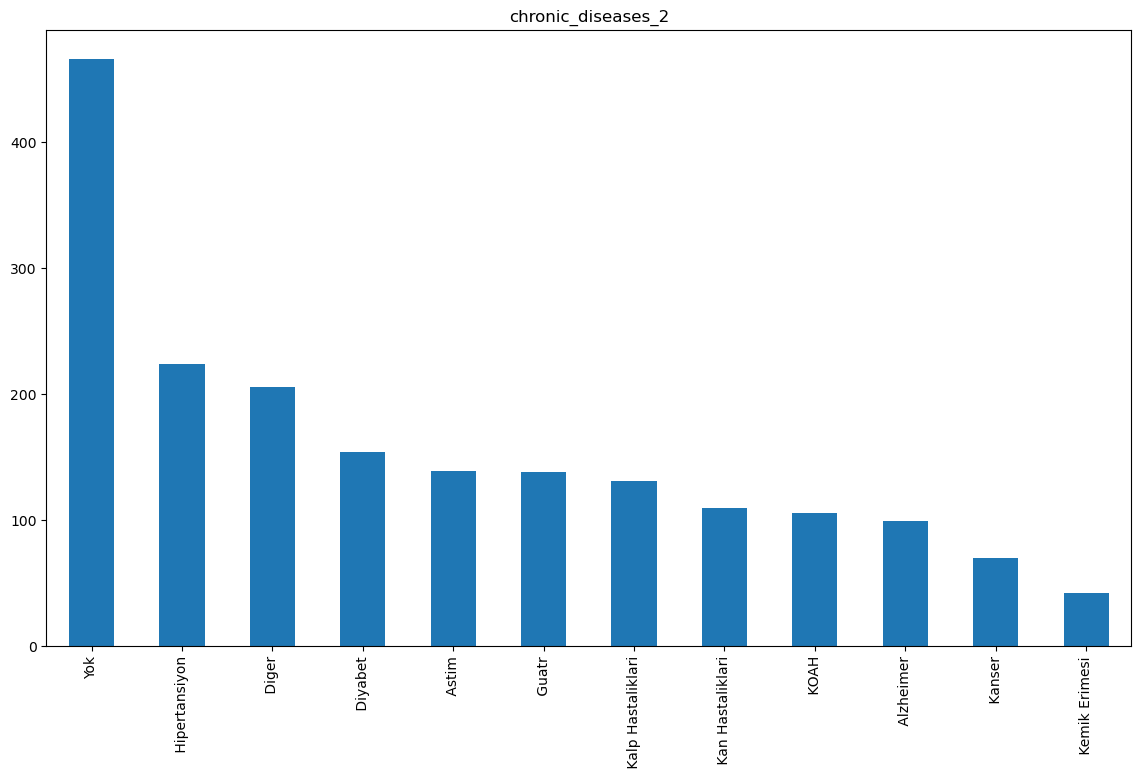

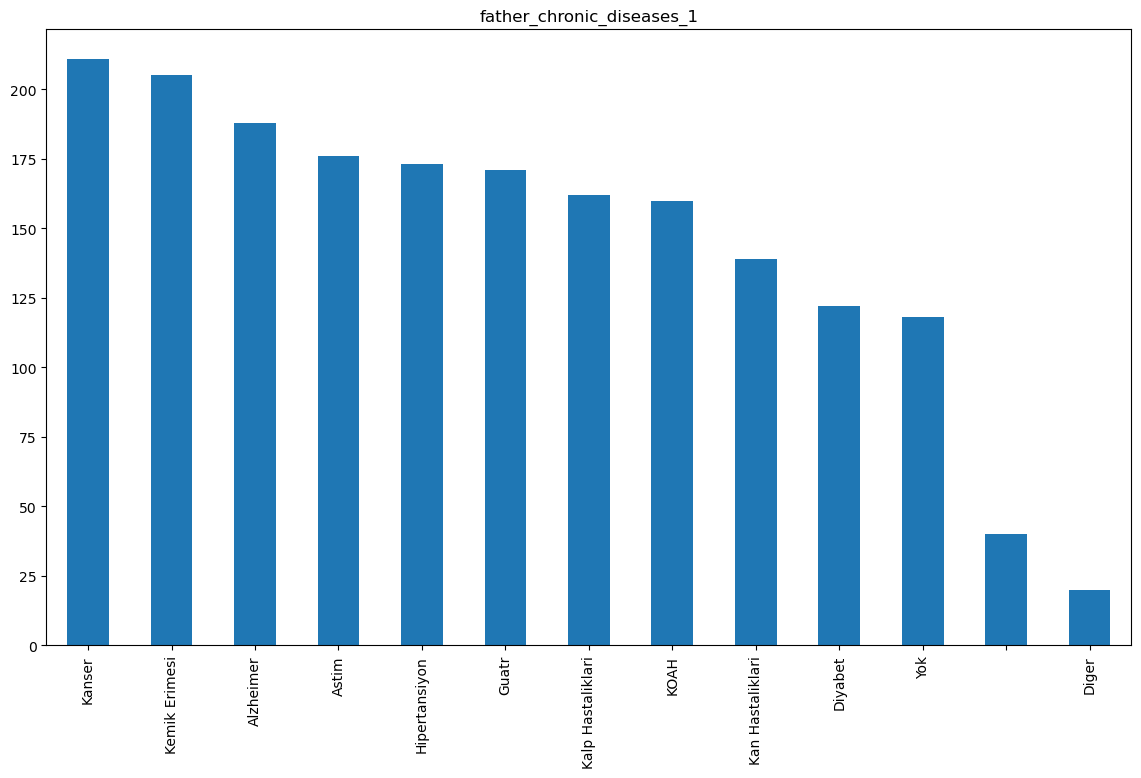

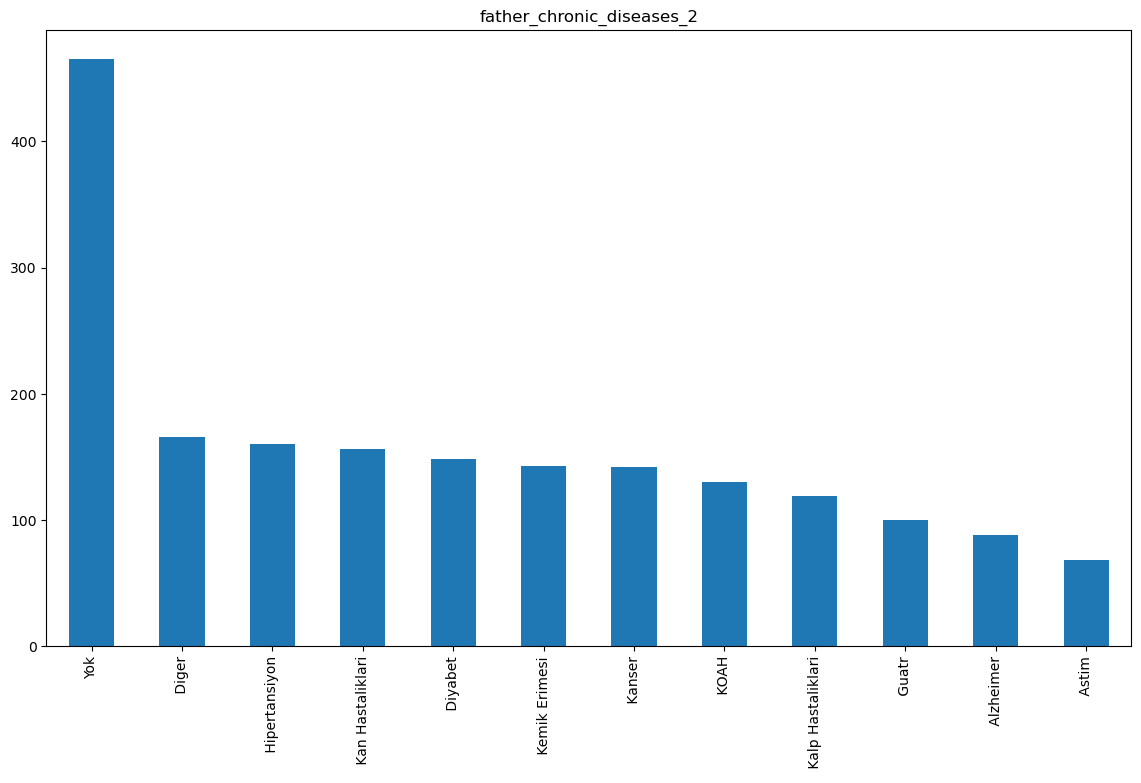

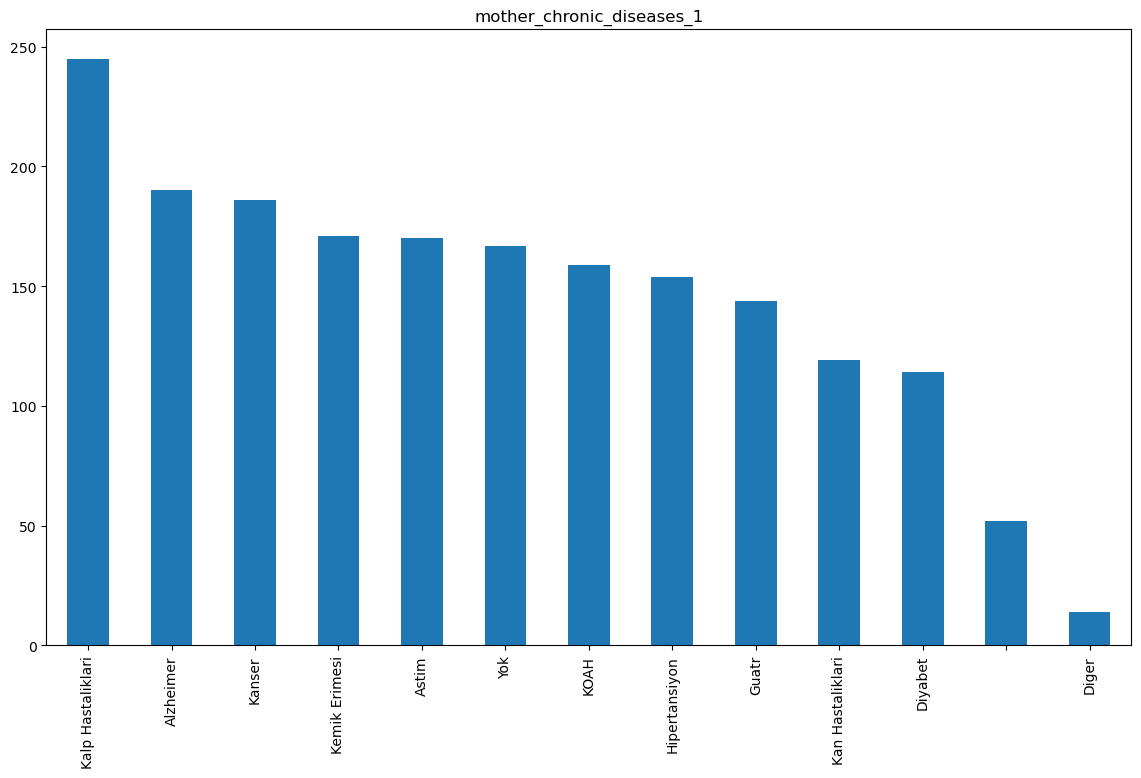

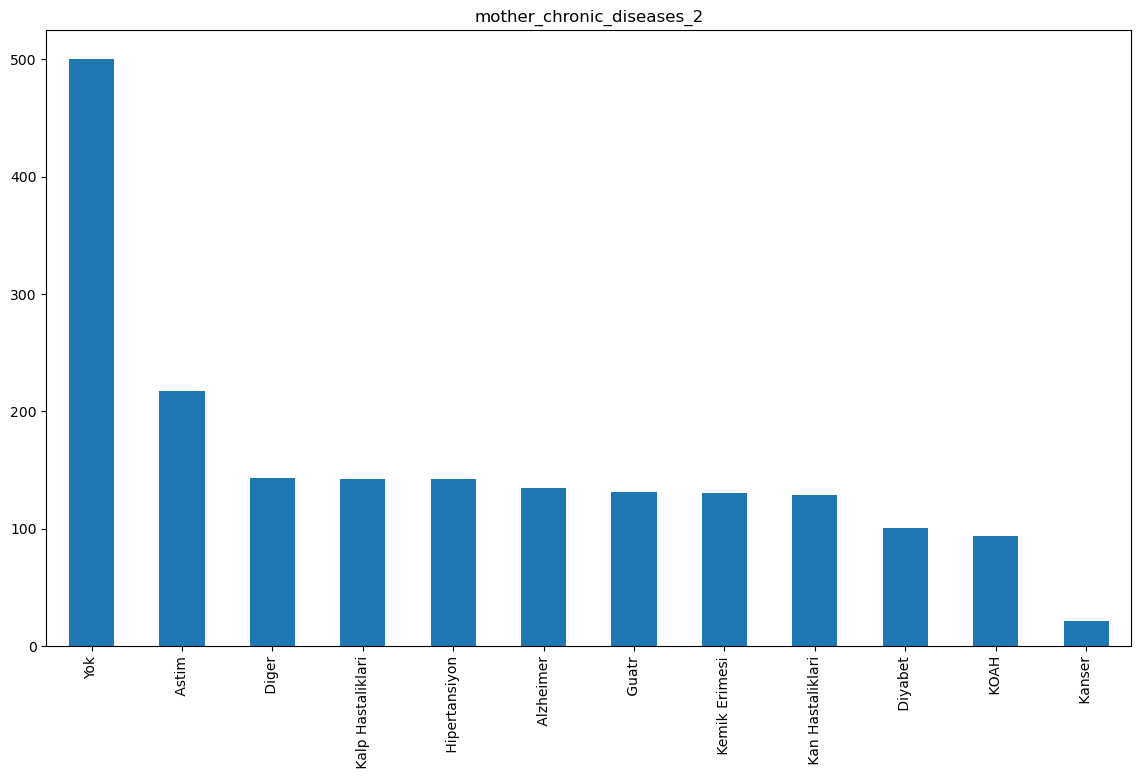

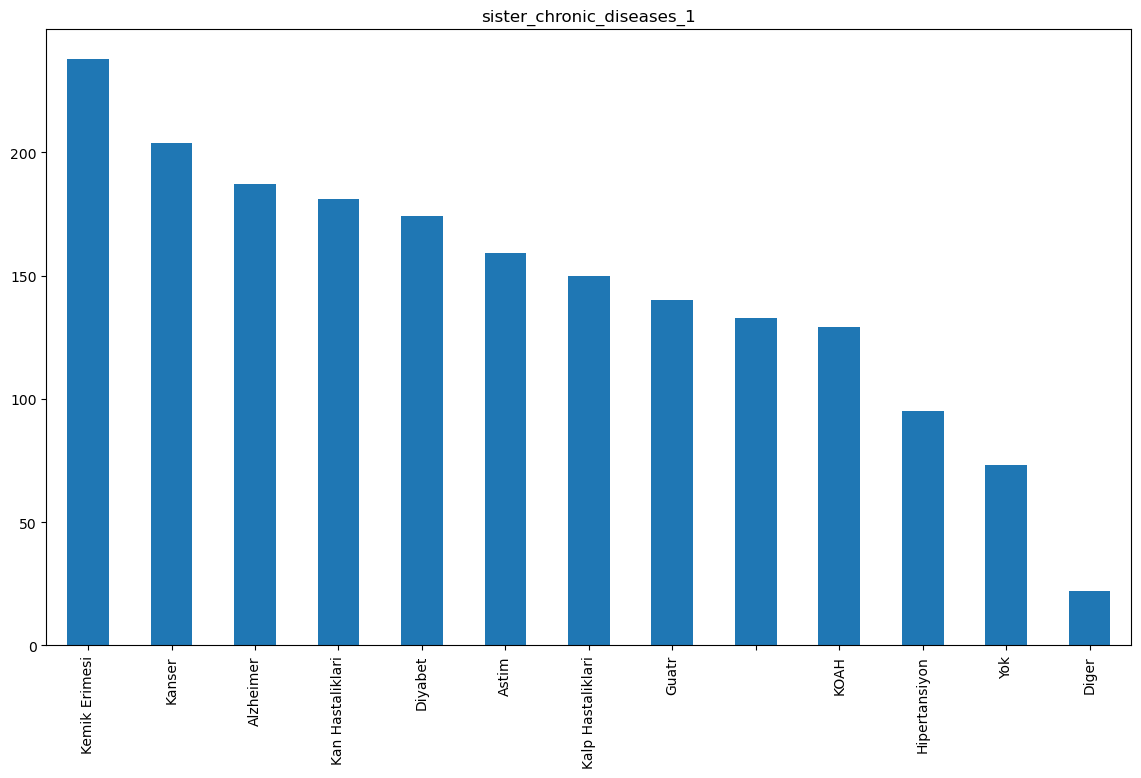

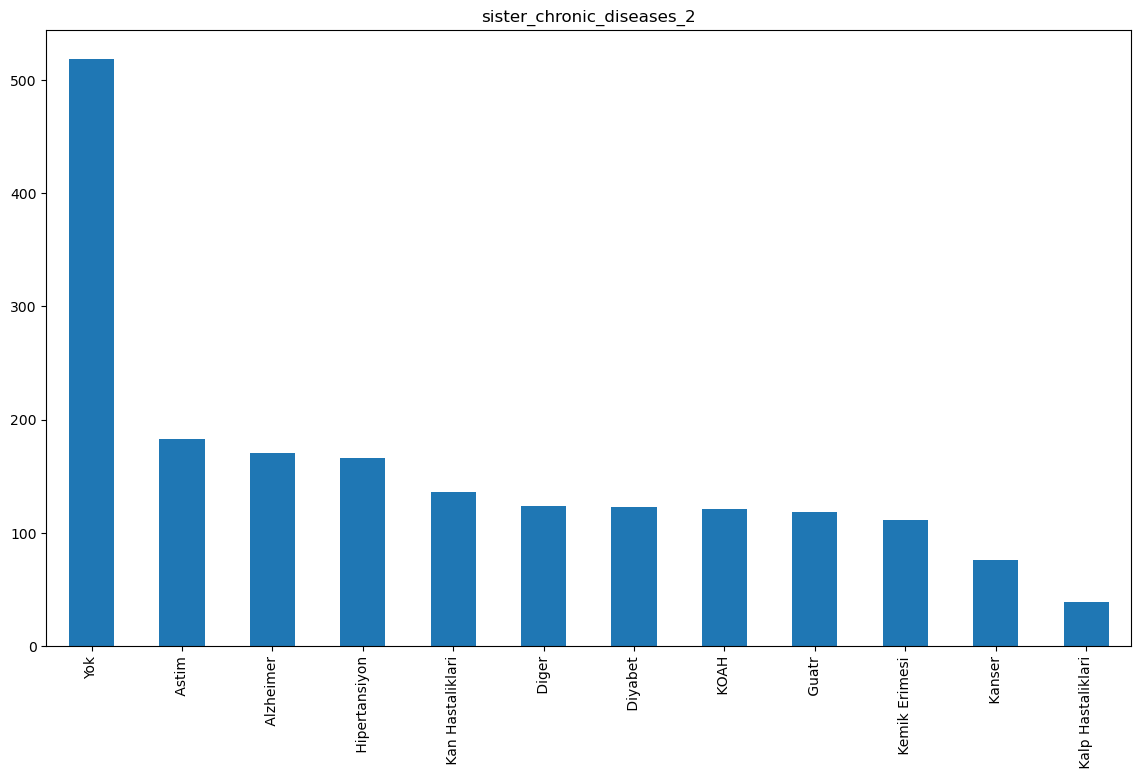

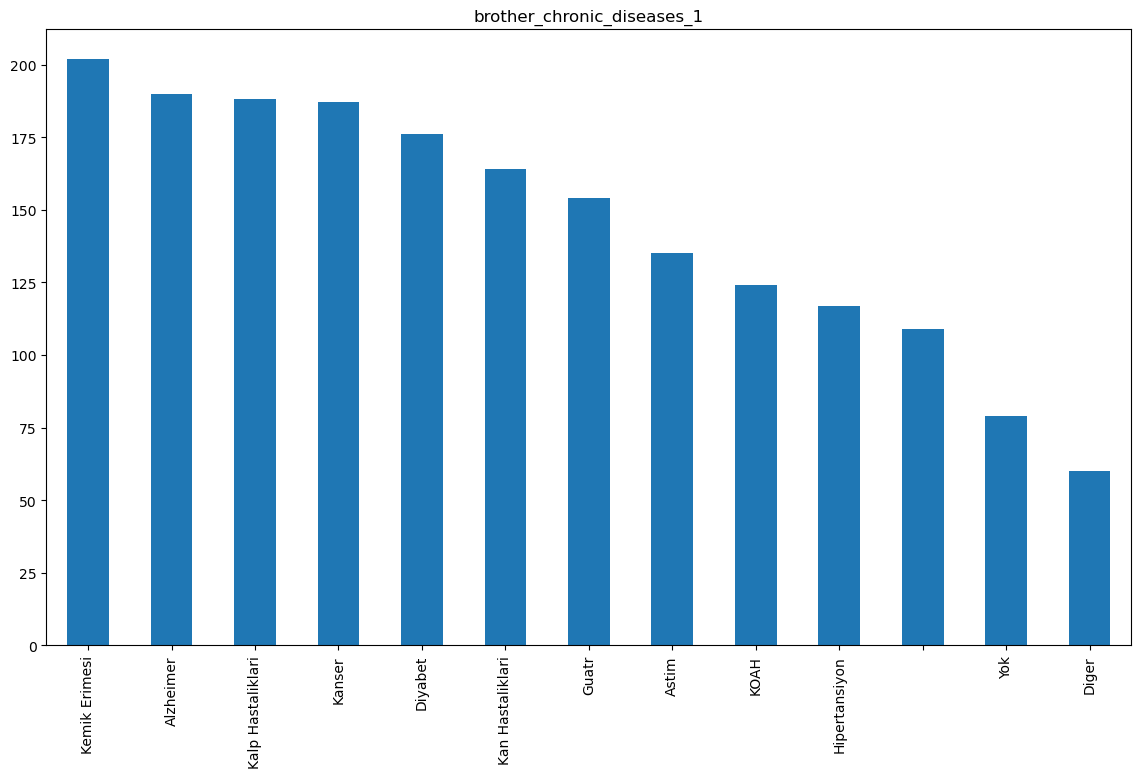

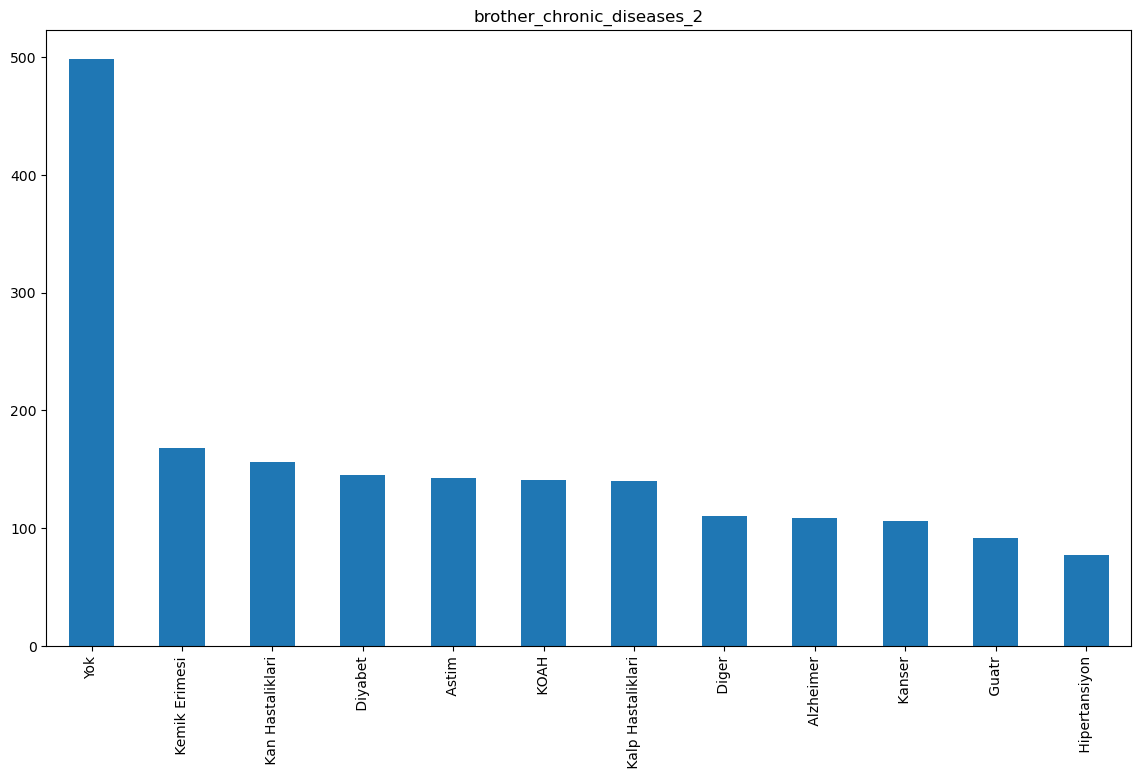

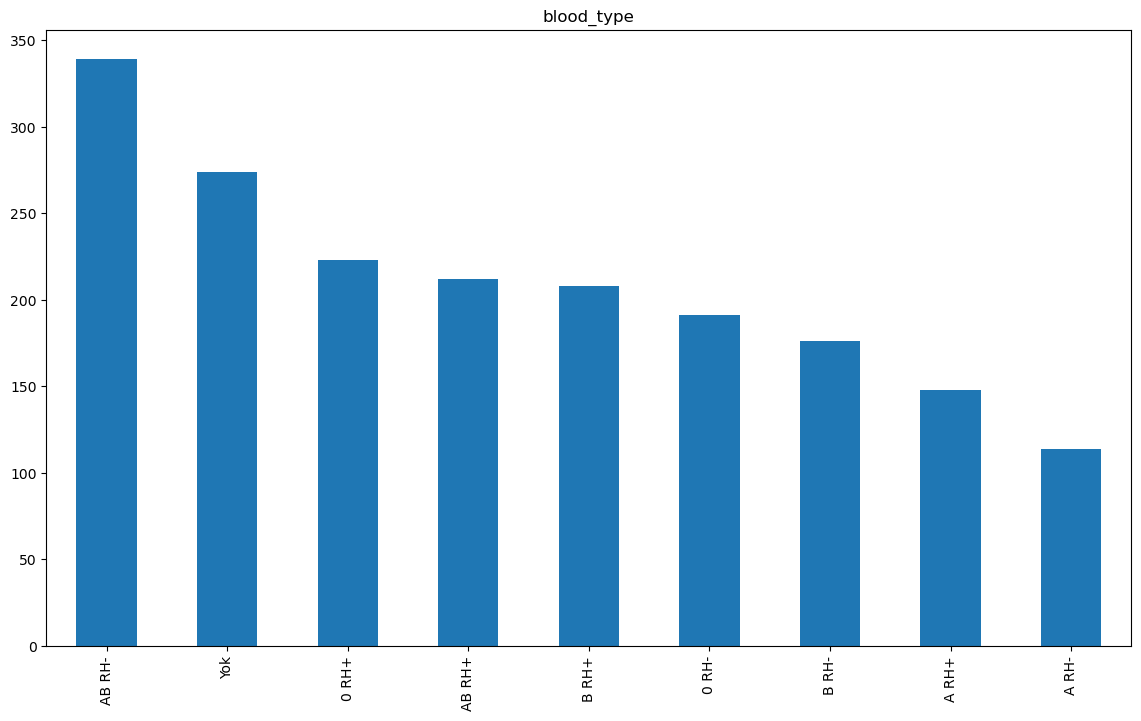

In [603]:
for col in nom_cat_attrs:
    plot_categories_spread(df_train, col)

## Clustering

In [616]:
from sklearn.cluster import KMeans

full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attrs),
 ("nom_cat", OneHotEncoder(), nom_cat_attrs)
 ])

train_prepared = full_pipeline.fit_transform(df_train)

kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
kmeans.fit(train_prepared)

d:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [617]:
cluster_df = pd.DataFrame(df_train)
cluster_df["cluster"] = kmeans.labels_

In [618]:
from sklearn.decomposition import PCA

pca = PCA(2)

pca_res = pca.fit_transform(train_prepared.toarray())
cluster_df['X'] = pca_res[:, 0]
cluster_df['Y'] = pca_res[:, 1]
cluster_df.head()

,user_id,gender,city,drug_name,side_effect,allergies,blood_type,weight,height,drug_start_day,...,mother_chronic_diseases_2,father_chronic_diseases_1,father_chronic_diseases_2,brother_chronic_diseases_1,brother_chronic_diseases_2,sister_chronic_diseases_1,sister_chronic_diseases_2,cluster,X,Y
958,134,Yok,Adana,mometasone furoate ointment,Gec Bosalma,Yogurt,0 RH-,80.000,197.0,7,...,Yok,KOAH,Guatr,Kemik Erimesi,Yok,Kemik Erimesi,Alzheimer,1,-1.460435,1.102922
936,167,Female,Trabzon,paroxetine,Agizda Farkli Bir Tat,Istiridye,A RH-,50.000,158.0,4,...,Yok,Hipertansiyon,Kan Hastaliklari,,Yok,Kanser,Hipertansiyon,2,-0.726364,-2.128670
301,140,Male,Trabzon,alprazolam,Istah Artisi,Toz,Yok,81.000,181.0,10,...,Kalp Hastaliklari,Guatr,Diger,KOAH,Diyabet,,Yok,2,0.855000,-3.056816
1671,70,Female,Kayseri,mirtazapine,Gucsuzluk,Havyar,B RH+,77.375,200.0,2,...,Kan Hastaliklari,Guatr,Kemik Erimesi,Alzheimer,Kalp Hastaliklari,Kalp Hastaliklari,Kanser,2,-1.729768,-2.068914
1484,15,Female,Ankara,lorazepam concentrate,Sinirlilik,Kopek,B RH+,69.000,188.0,1,...,Yok,Astim,Kemik Erimesi,KOAH,Alzheimer,KOAH,Diyabet,2,-1.749423,-1.060131


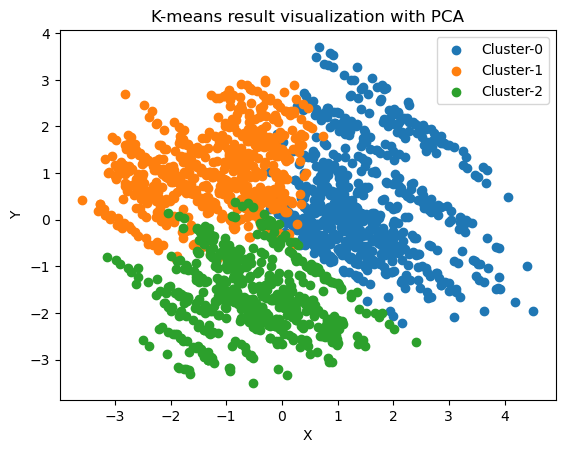

In [619]:
cluster_0 = cluster_df[cluster_df["cluster"] == 0]
cluster_1 = cluster_df[cluster_df["cluster"] == 1]
cluster_2 = cluster_df[cluster_df["cluster"] == 2]

plt.scatter(cluster_0['X'], cluster_0['Y'], label="Cluster-0")
plt.scatter(cluster_1['X'], cluster_1['Y'], label="Cluster-1")
plt.scatter(cluster_2['X'], cluster_2['Y'], label="Cluster-2")
plt.legend()
plt.title("K-means result visualization with PCA")
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Text(0.5, 1.0, 'Cluster 0')

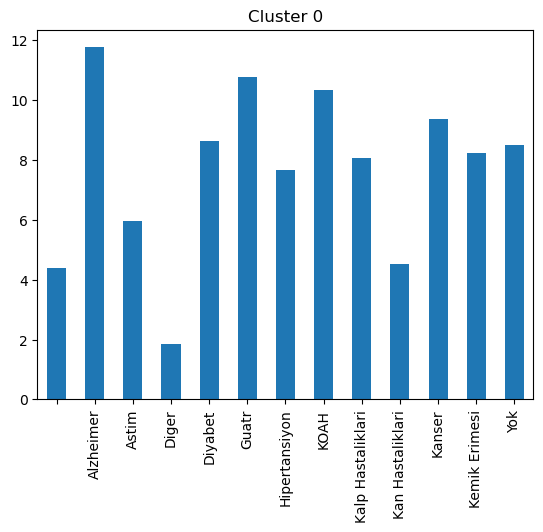

In [687]:
cluster_0_norm = (cluster_0['mother_chronic_diseases_1'].value_counts().sort_index() / cluster_0['father_chronic_diseases_1'].value_counts().sum()) * 100
cluster_0_norm.plot(kind="bar") # 51 - 85 yaş arası ortalama 71 yaşındaki kişiler
plt.title("Cluster 0")

Text(0.5, 1.0, 'Cluster 1')

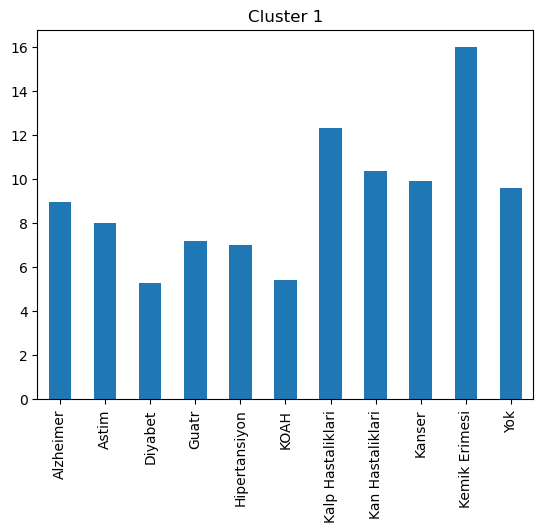

In [688]:
cluster_1_norm = (cluster_1['mother_chronic_diseases_1'].value_counts().sort_index() / cluster_1['father_chronic_diseases_1'].value_counts().sum()) * 100
cluster_1_norm.plot(kind="bar") # 13 - 50 yas arası ortalama 29 yasındaki kişiler
plt.title("Cluster 1")

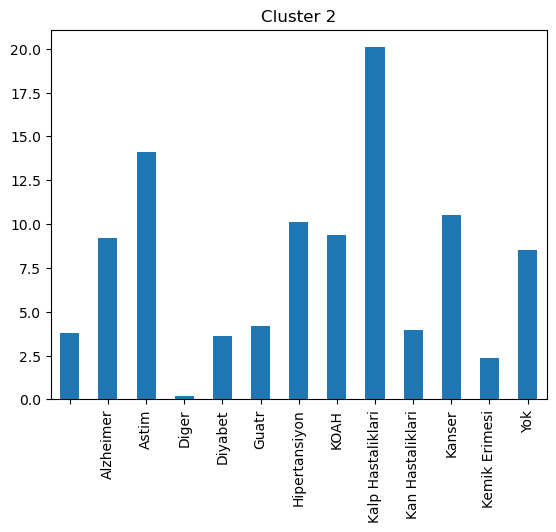

In [689]:
cluster_2_norm = (cluster_2['mother_chronic_diseases_1'].value_counts().sort_index() / cluster_2['father_chronic_diseases_1'].value_counts().sum()) * 100
cluster_2_norm.plot(kind="bar") # 13 - 84 yaş arası ortalama 52 yaşındaki kişiler cinsiyet dağılımı benzer
plt.title("Cluster 2")
plt.show()

<Axes: >

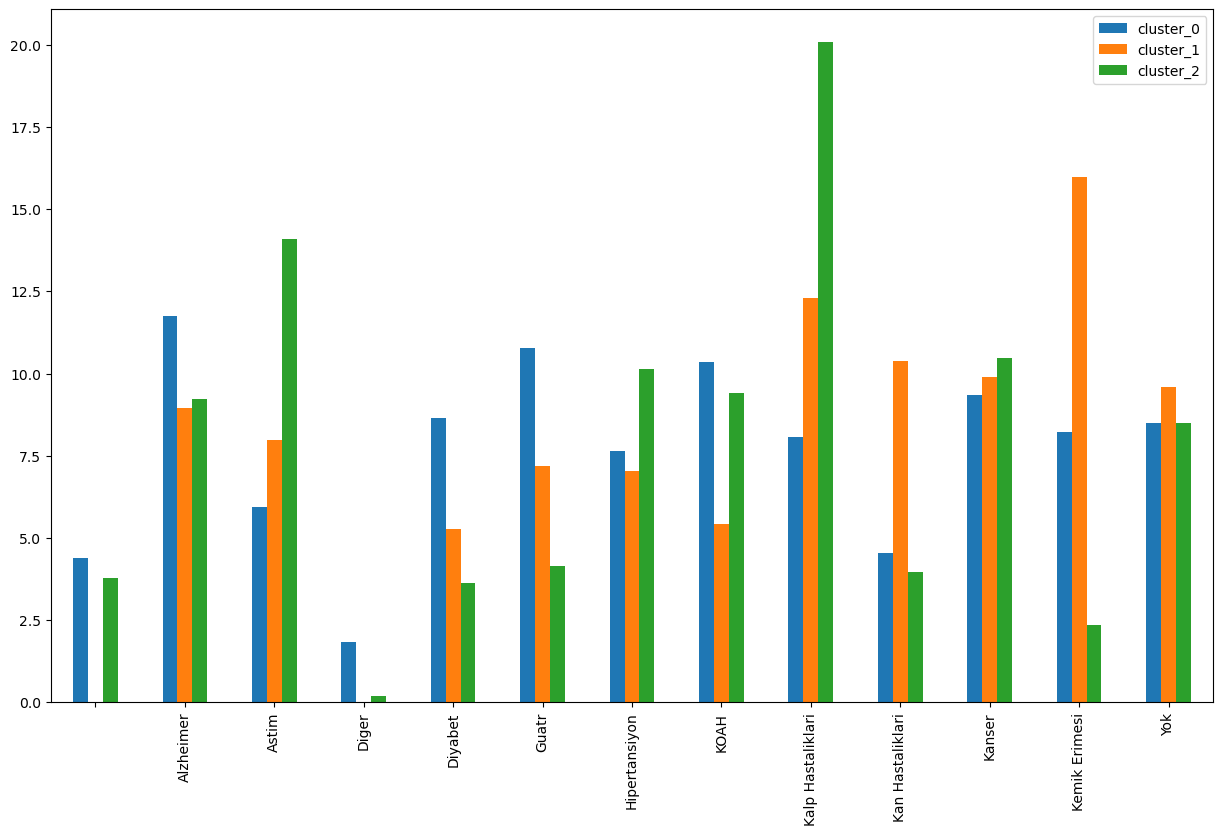

In [690]:
fig, axes = plt.subplots(1, 1, figsize=(15, 9), sharey=True)

clusters_stacked = pd.DataFrame({'cluster_0': cluster_0_norm, 'cluster_1': cluster_1_norm, 'cluster_2': cluster_2_norm})
clusters_stacked.plot.bar(ax=axes)

## Random Forest Train and Test Score

In [623]:
# Random forest train score
clf.score(X_train, y_train)

1.0

In [624]:
# Random forest test score
clf.score(X_test, y_test)

0.8432203389830508